In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [5]:
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

# 1. Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arrière)
- Développer une première stratégie de modélisation

## Checklist de base
### Analyse de Forme :
- **Variable target** : TotalGHGEmissions & SiteEnergyUseWN(kBtu) --> choix par rapport aux condition de Metéo
- **Lignes et colonnes** : (3376, 46) --> dont (1546, 46) pour les batiments NonRésidentiels
- **Types de variables** : qualitatives : 15, quantitative : 30 (22 float et 8 int) et booléen : 1
- **Analyse des valeurs manquantes** : 5 variables qui ont plus de 80% de NaN (à supprimer probablement), 2 variables qui sont a 50% de NaN, 20 variables qui ont 0% de NaN (bonne nouvelle) et le reste des variables sont entre 0,1% a 25% de NaN. **!Remarque!** : Il y a plusieurs variables qui ont le même % de NaN (lien entre ces variables)

### Analyse de Fond :
- **Visualisation de la target** : TotalGHGEmissions-->Suis une distribution presque normal (avec log_scale), mais se concentrée sur un interval de O à 100. SiteEnergyUseWN(kBtu)--> suis presque la même distribution que la TotalGHGEmissions (mais plus concentrée)
- **Signification des variables** :
    - **Variables quantitatives** : les variables (deux a deux) suivent une même distribution (**hypothèse** : *elles donnent les mêmes info mais avec des unités différentes*). Plus de propriétés ont été construit a partir de 1900-->1930 puis entre 1960-->2019 (moins de construction entre 1930-->1945 : peut être due aux guerres)
    - **Variables qualitatives** : il y'a trops de catégories (donc ça va être très difficile de les exploiter)
- **Relation Variables / Target** :
    - **Target / Quantitatives** : 1 - Nous voyons que + les bâtiment consomment d'energy + ils êmettent des gaz a effet de serre
                                    2 - L'année de construction des bâtiment à une tendence difficile à interpreter ( Plus un bâtiment est recent plus
                                      il consomme)--> avec le linespot je m'attendais a une courbe (variation) decroissante.
    - **Target / Qualitatives** : Nous observons que les propriétés usues des secteurs Santé/Recherches consomment an moyenne plus d'Energie (donc produisent plus de GES) et inversement les Secteurs Industries/Logistique.
    - **Relation Variable / Variable** : Nous observons que plusieurs variable sont corrélées a nos cible, donc sûrement des variables très importantes pour la prédiction de nos cible. On obserse que nos cible (qui sont très corrélées entres elles) ont les mêmes corrélation (qui est très forte) avec ces variables :
          - **NaturalGas(therms), NaturalGas(kbtu), Electricity(kwh), Electricity(kbtu), SteamUse(kbtu), siteEnergyUse(kbtu), PropertyGFABuilding,
              PropertyGFATotal**
      Il y'a des variables qui sont probablement redondante(très corrélées entre elle) :
          - **PropertyGFATotal <--> PropertyGFABuiding
          - SiteEUI <--> SourceEUI, SourceEUIWN, SiteEUIWN
          - SiteEnergyUse <--> SiteEnergyUseWN
          - Electricity(KBtu) <--> Electricity(kWh)
          - NaturalGas(therms) <--> NaturalGas(kbtu)** --> *Des variables redondantes a supprimer ( je suis allé voir la déf. de chaque variable avant de les supprimer)*
      
      -  Les variables qui sont directement calculées à partir de la consommation d’énergie ne doivent pas être utilisées comme prédicteurs car :

            - Elles sont dérivées de la cible, ce qui crée une fuite de données (data leakage).
            - Elles ne sont pas disponibles pour un bâtiment dont on veut prédire les émissions et la consommation d’énergie, puisqu’on cherche
            - justement à estimer ces valeurs avant qu’elles ne soient mesurées.
    - Les variables SiteEnergyUseWN(kBtu) et TotalGHGEmissions sont fortement impactées par le type de bâtiment.
    → Logique, car différents types de bâtiments consomment et émettent du CO₂ différemment.

    NumberofFloors, NumberofBuildings et PropertyGFAParking sont aussi influencés.
    → Cela confirme que le type de bâtiment affecte fortement sa structure physique.

    YearBuilt a une influence plus faible (p-value = 0.011).
    → Il y a une différence selon le type de bâtiment, mais moins marquée.

# Analyse de la forme des données

In [9]:
df.shape

(3376, 46)

In [11]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

<Axes: >

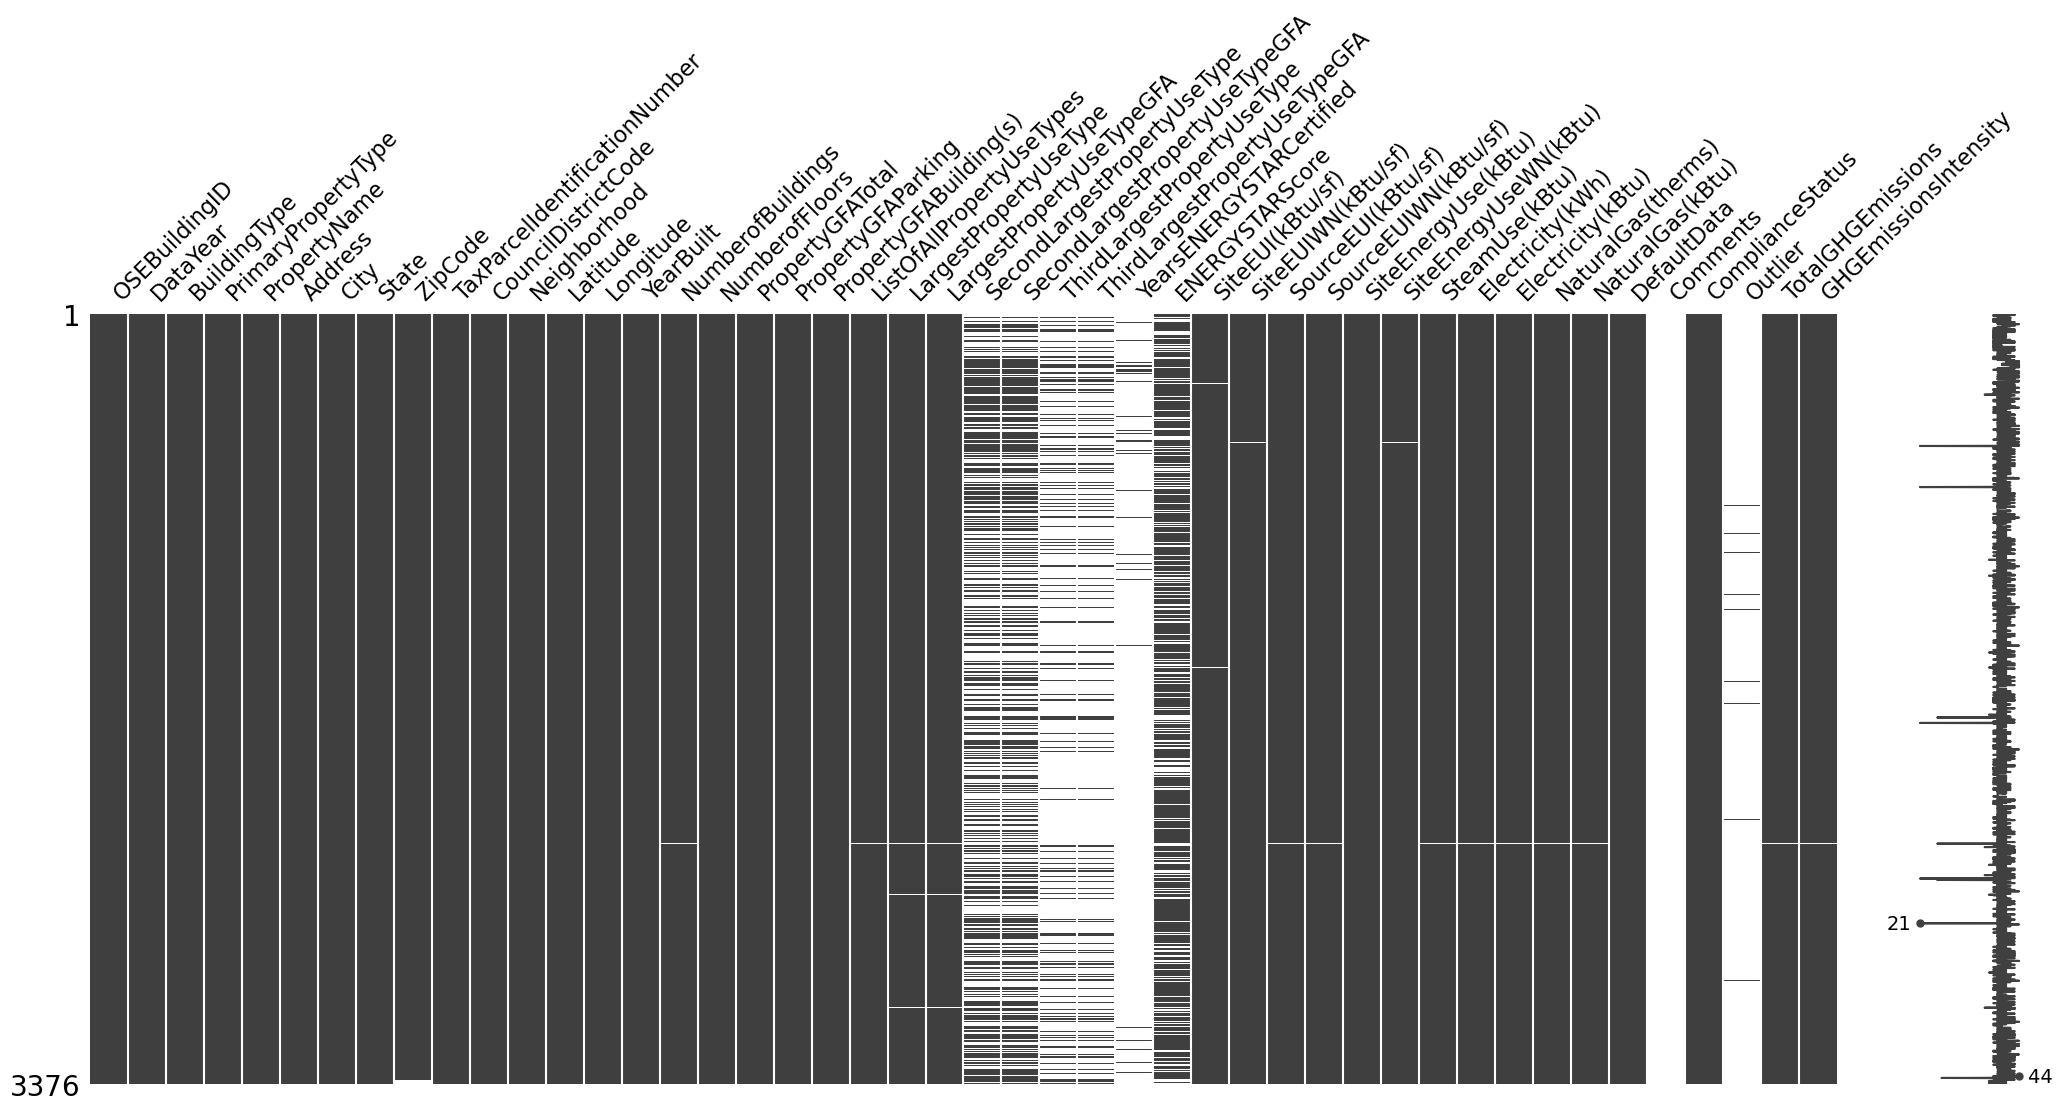

In [13]:
msno.matrix(df)

In [15]:
(df.isnull().mean()*100).sort_values(ascending = False)

Comments                           100.000000
Outlier                             99.052133
YearsENERGYSTARCertified            96.475118
ThirdLargestPropertyUseType         82.345972
ThirdLargestPropertyUseTypeGFA      82.345972
SecondLargestPropertyUseType        50.266588
SecondLargestPropertyUseTypeGFA     50.266588
ENERGYSTARScore                     24.970379
LargestPropertyUseTypeGFA            0.592417
LargestPropertyUseType               0.592417
ZipCode                              0.473934
ListOfAllPropertyUseTypes            0.266588
SourceEUIWN(kBtu/sf)                 0.266588
SourceEUI(kBtu/sf)                   0.266588
Electricity(kWh)                     0.266588
Electricity(kBtu)                    0.266588
NaturalGas(therms)                   0.266588
NaturalGas(kBtu)                     0.266588
TotalGHGEmissions                    0.266588
SteamUse(kBtu)                       0.266588
GHGEmissionsIntensity                0.266588
NumberofBuildings                 

**IDENTIFICATION DE DUBLOND :**
- **OSEBuildingID** : 0 doublons (*qui est unique à chaque propriété*)
- **PropertyName** : 14 doublons (après vérification : *ce ne sont pas des doublons*)
- **Longitude ,Latitude** : 93 doublons (après vérification : *pas doublons car plusieur appartement->propriétés peuvent être sur le même batiment*)

**ETUDES DE QUELQUES VARIABLES :**
- **BuildingType** : NonResidential --> 1460, Nonresidential COS --> 85, Nonresidential WA --> 1 et le reste des données --> [ Multifamily LR (1-4), Multifamily MR (5-9), Multifamily HR (10+), SPS-District K-12, Campus ]
    - Variable a supprimer après avoir récuperer les bon données par ce qu'elle n'apporte plus de valeur
- **DefaultData** : False-->3254, True-->113 (**Attention**)--> demandées à la source pourquoi cette variable à été crée ?
- **PrimaryPropertyType** : Regrouper ces catégories en fonction de leur usage principal dans une nouvelle variable ('PrimaryPropertyType_General').

**TYPE DE VARIABLE DANS LES DONNEES DES BATIMENT NONRESIDENTIELS**
- **Object** : 2 (['PrimaryPropertyType', 'ListOfAllPropertyUseTypes'])
- **float64** : 15
- **int64** : 5

In [7]:
df_seatle = df.copy()

In [9]:
# Supprimons les colonnes ayant plus de 80% de NaN
df_seatle = df_seatle[df_seatle.columns[(df_seatle.isnull().mean()*100)<80]]

In [11]:
# Avant tout récuperons les données des bâtiments non destinés à l’habitation
'''df_seatle.loc[
    (df_seatle['BuildingType'] == 'NonResidential') |
    (df_seatle['BuildingType'] == 'Nonresidential WA') |
    (df_seatle['BuildingType'] == 'Nonresidential COS'), :].shape''' # ou
df_seatle_NR = df_seatle.loc[df_seatle['BuildingType'].str.startswith(('NonResidential', 'Nonresidential'))  , :]
df_seatle_NR.shape

(1546, 41)

In [13]:
# Supprimons les lignes (propriété) n’ayant pas de valeur cible SiteEnergyUseWN(kBtu)
df_seatle_NR = df_seatle_NR.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'])
df_seatle_NR.shape

(1543, 41)

In [15]:
# liste de variables qui ne sont pas intérréssant pour notre étude (émission de C02 --> Consommation d'Energie)
delete_col = ['OSEBuildingID', 'DataYear', 'PropertyName', 'TaxParcelIdentificationNumber',
             'Address', 'City', 'State', 'ZipCode', 'Longitude', 'Latitude', 'Neighborhood','CouncilDistrictCode', 
              'LargestPropertyUseType', 'SecondLargestPropertyUseType','LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA', 'BuildingType', 'ComplianceStatus', 'DefaultData']
df_seatle_NR = df_seatle_NR.drop(columns= delete_col, axis = 1)
df_seatle_NR.shape

(1543, 22)

<Axes: >

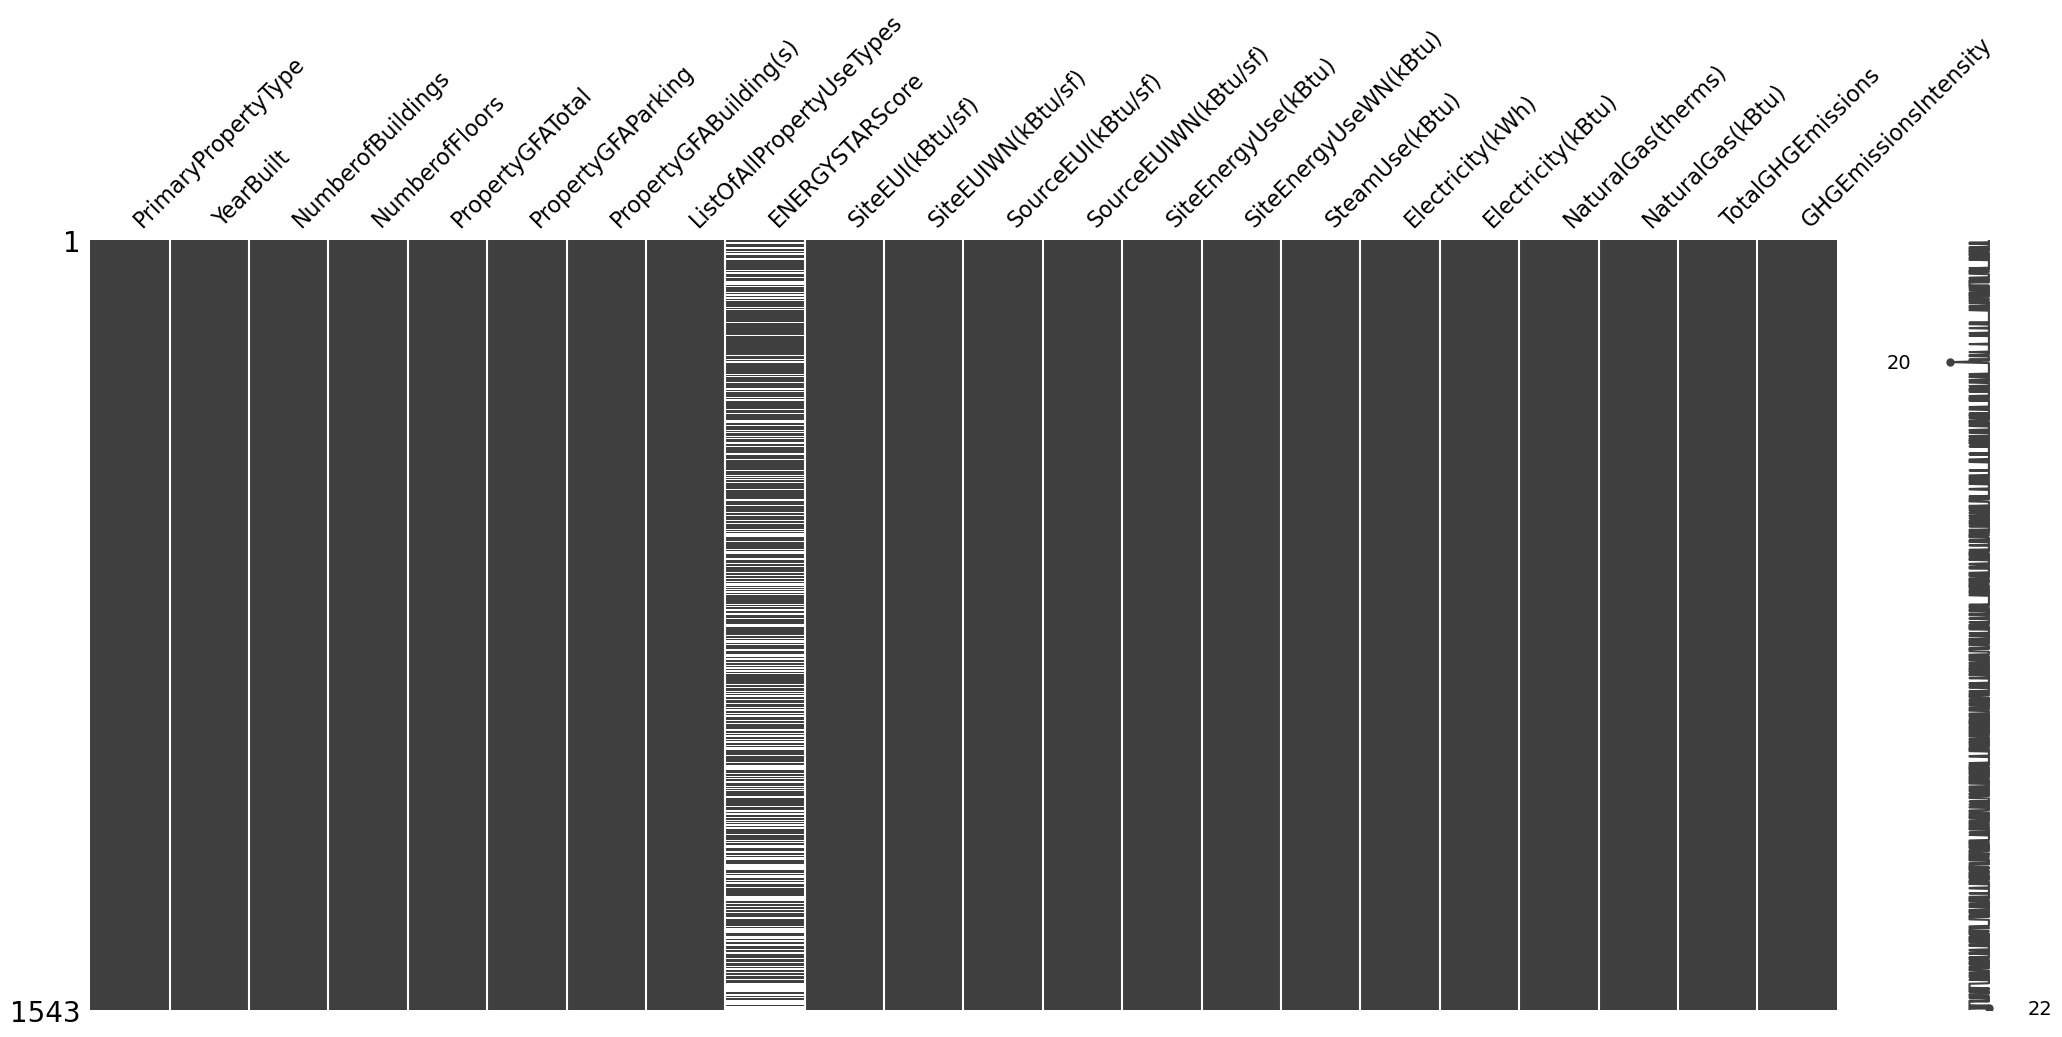

In [28]:
msno.matrix(df_seatle_NR)

# Analyse du fond des données

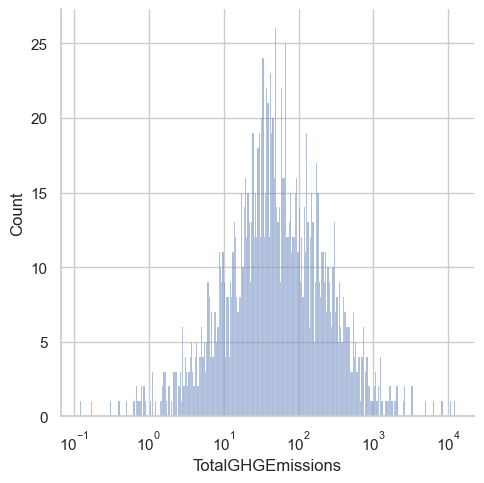

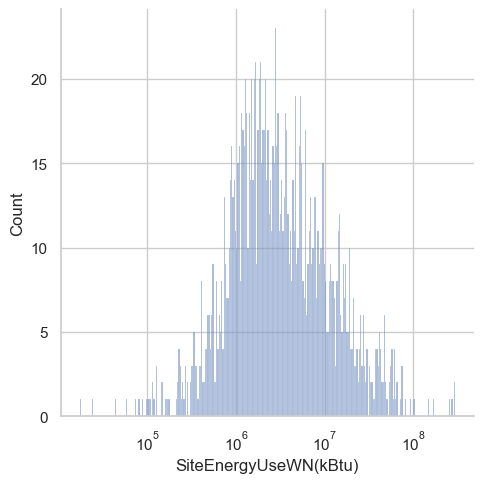

In [17]:
# Examen de la colonne targets 
sns.set(style='whitegrid')
sns.displot(df_seatle_NR['TotalGHGEmissions'],  kde = True, log_scale = True,bins = 300 )
sns.displot(df_seatle_NR['SiteEnergyUseWN(kBtu)'],  kde = True, log_scale = True,bins = 300 )
plt.show()

### Visualisation des variables

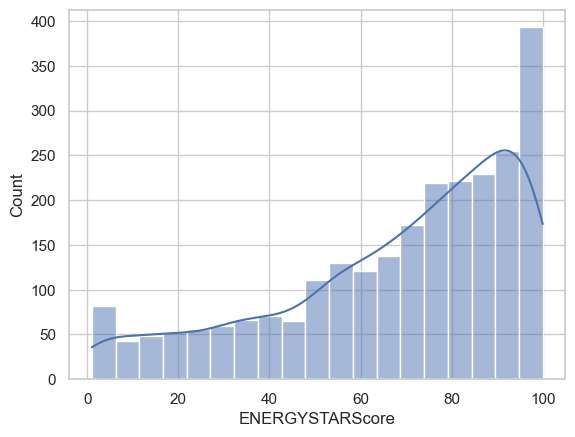

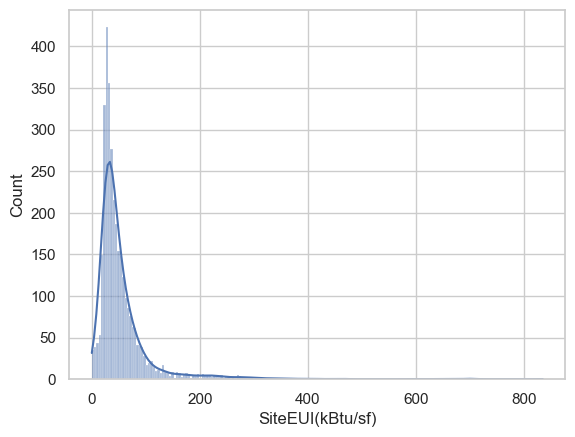

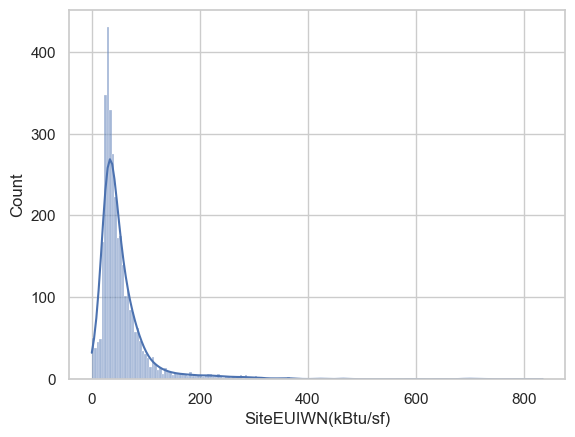

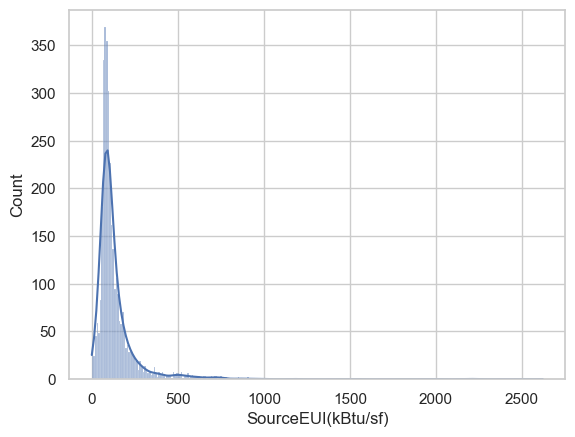

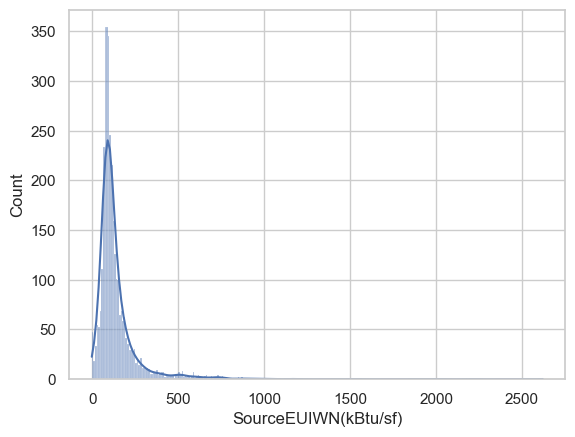

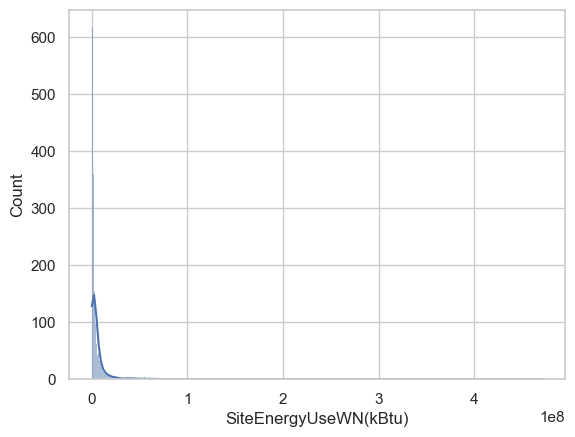

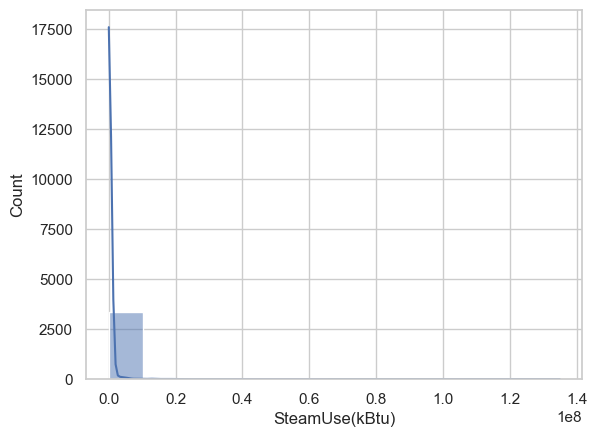

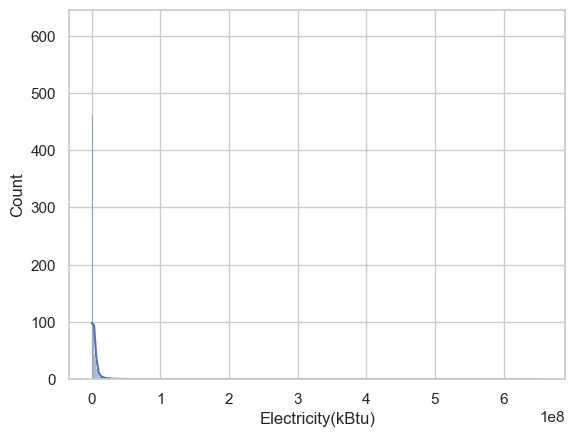

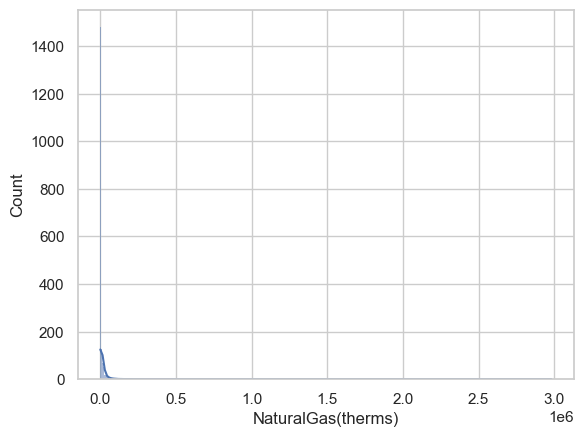

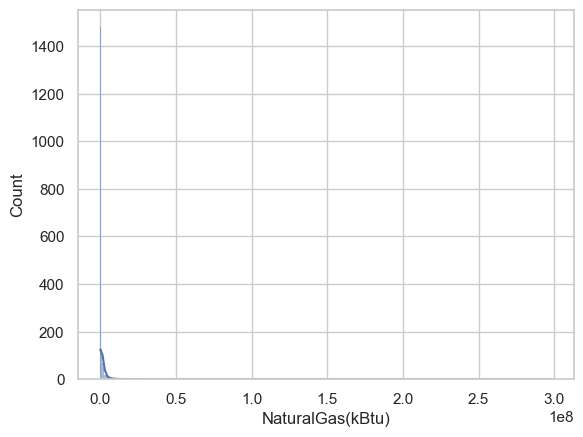

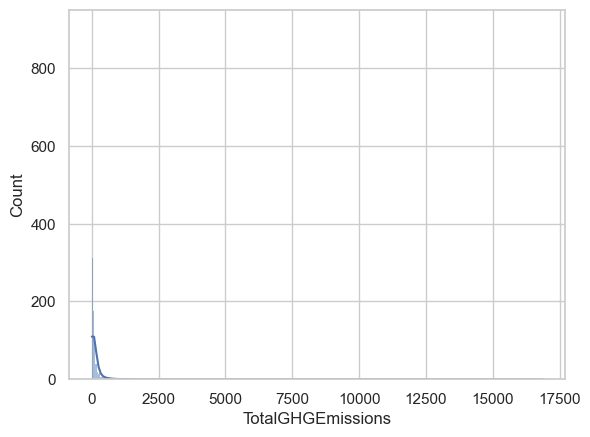

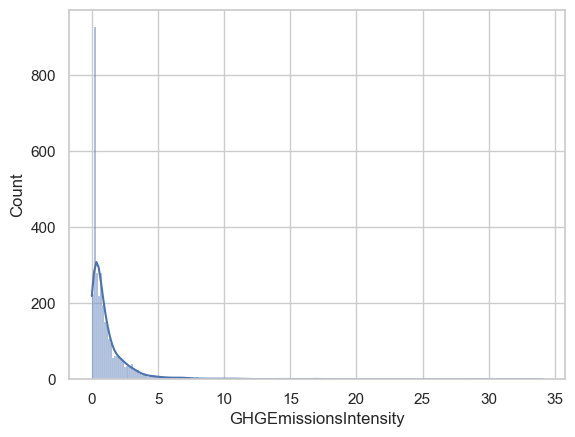

In [34]:
# Pour les variables de types float
for col in df_seatle_NR.select_dtypes(include='float'):
    sns.histplot(df[col], kde=True)
    plt.show()

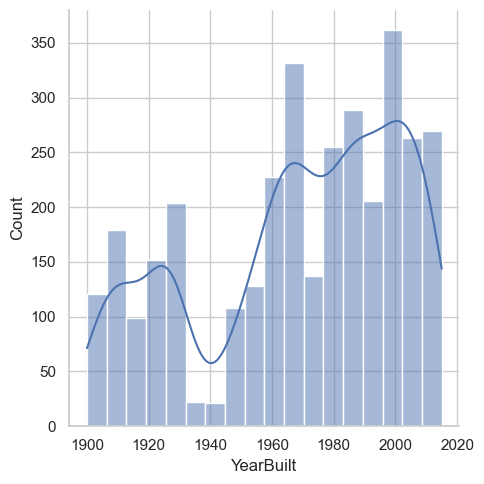

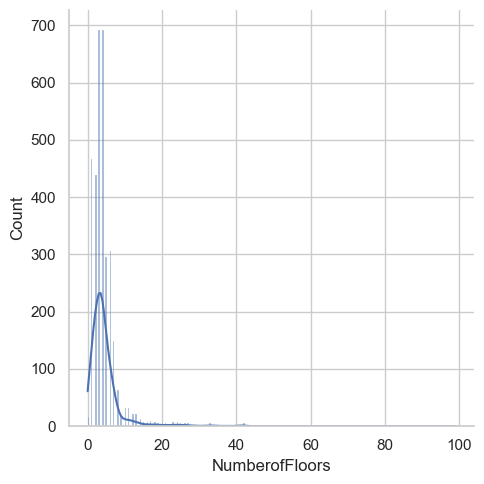

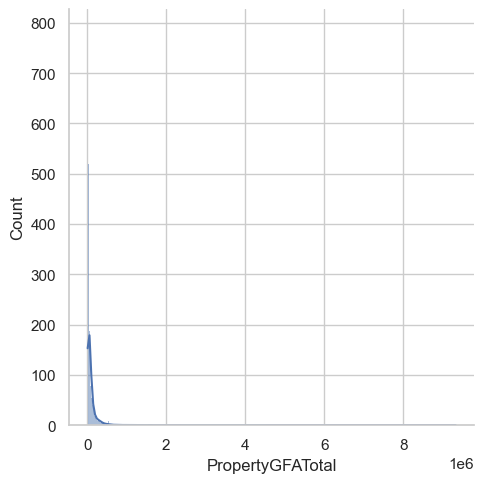

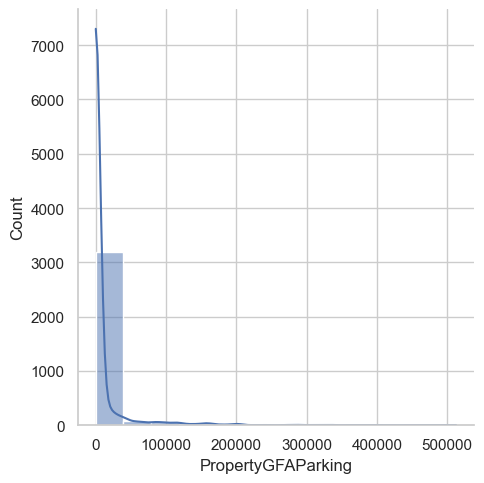

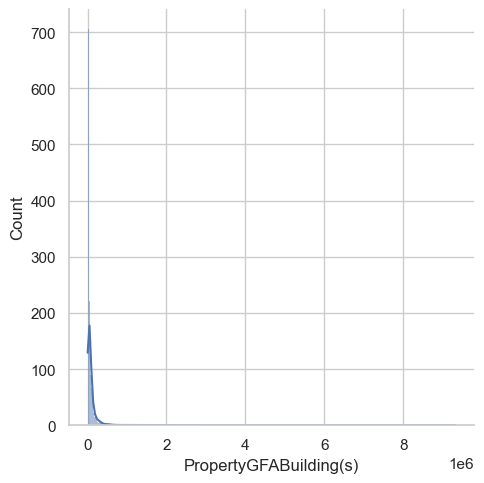

In [35]:
# Pour les variables de types int
for col in df_seatle_NR.select_dtypes(include='int'):
    sns.displot(df[col], kde=True)
    plt.show()

In [38]:
# Pour les variables de types object (Trop de catégories dans la dernière variable) --> Liste of all categoriesUse
for col in df_seatle_NR.select_dtypes(include='object'):
    print(f'Les diffirents catégories dans ma variable {col} sont :\n')
    print(f'{df_seatle_NR[col].unique()}')
    print('-'*100)

Les diffirents catégories dans ma variable PrimaryPropertyType sont :

['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'K-12 School' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Supermarket / Grocery Store' 'Laboratory'
 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily' 'Office']
----------------------------------------------------------------------------------------------------
Les diffirents catégories dans ma variable ListOfAllPropertyUseTypes sont :

['Hotel' 'Hotel, Parking, Restaurant' 'Hotel, Parking, Swimming Pool'
 'Police Station' 'Other - Entertainment/Public Assembly' 'Hotel, Parking'
 'Data Center, Library, Parking'
 'Fitness Center/Health Club/Gym, Office, Swimming Pool'
 'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Aut

In [19]:
# Regrouper ces catégories en fonction de leur usage principal
def regrouper_categories(category):
    mapping = {
        # Bureaux et Éducation
        'Small- and Mid-Sized Office': 'Bureau / Éducation',
        'Large Office': 'Bureau / Éducation',
        'Office': 'Bureau / Éducation',
        'Medical Office': 'Bureau / Éducation',
        'University': 'Bureau / Éducation',
        'K-12 School': 'Bureau / Éducation',

        # Santé et Recherche
        'Hospital': 'Santé / Recherche',
        'Laboratory': 'Santé / Recherche',
        'Senior Care Community': 'Santé / Recherche',

        # Hébergement
        'Hotel': 'Hébergement',
        'Residence Hall': 'Hébergement',

        # Commerce et Services
        'Retail Store': 'Commerce / Services',
        'Supermarket / Grocery Store': 'Commerce / Services',
        'Restaurant': 'Commerce / Services',

        # Industrie et Logistique
        'Warehouse': 'Industrie / Logistique',
        'Distribution Center': 'Industrie / Logistique',
        'Refrigerated Warehouse': 'Industrie / Logistique',
        'Self-Storage Facility': 'Industrie / Logistique',

        # Lieux publics et divers
        'Worship Facility': 'Lieux Publics / Divers',
        'Mixed Use Property': 'Lieux Publics / Divers',
        'Low-Rise Multifamily': 'Lieux Publics / Divers',
        
        # Autres
        'Other': 'Autres'
    }

    return mapping.get(category, 'Autres')  # Par défaut, on met "Autres" pour les catégories non listées

In [21]:
# Création d'une nouvelle colonne dans le dataset
df_seatle_NR['PrimaryPropertyType_General'] = df_seatle_NR['PrimaryPropertyType'].apply(regrouper_categories)

In [23]:
if 'PrimaryPropertyType' in df_seatle_NR.columns:
    df_seatle_NR = df_seatle_NR.drop(columns='PrimaryPropertyType')
df_seatle_NR['PrimaryPropertyType_General'].value_counts()
# Je suis passé de 22 à 7 catégories

PrimaryPropertyType_General
Bureau / Éducation        561
Industrie / Logistique    280
Autres                    241
Lieux Publics / Divers    182
Commerce / Services       142
Hébergement                97
Santé / Recherche          40
Name: count, dtype: int64

### Relation Variables / Target

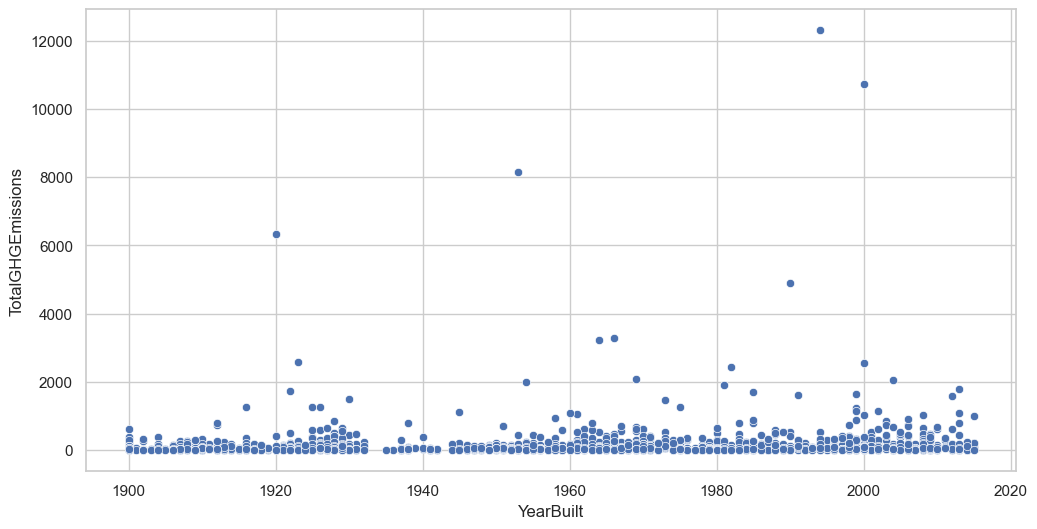

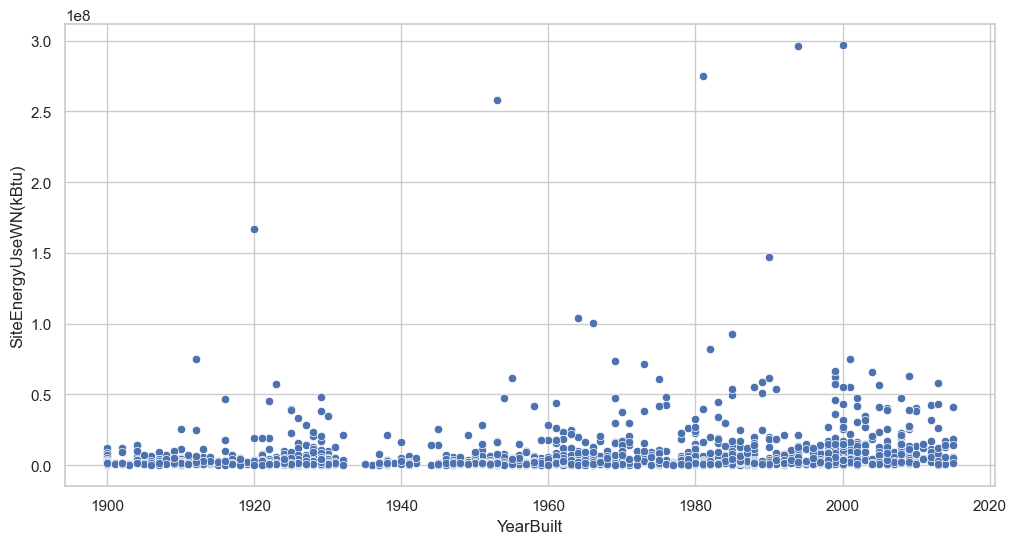

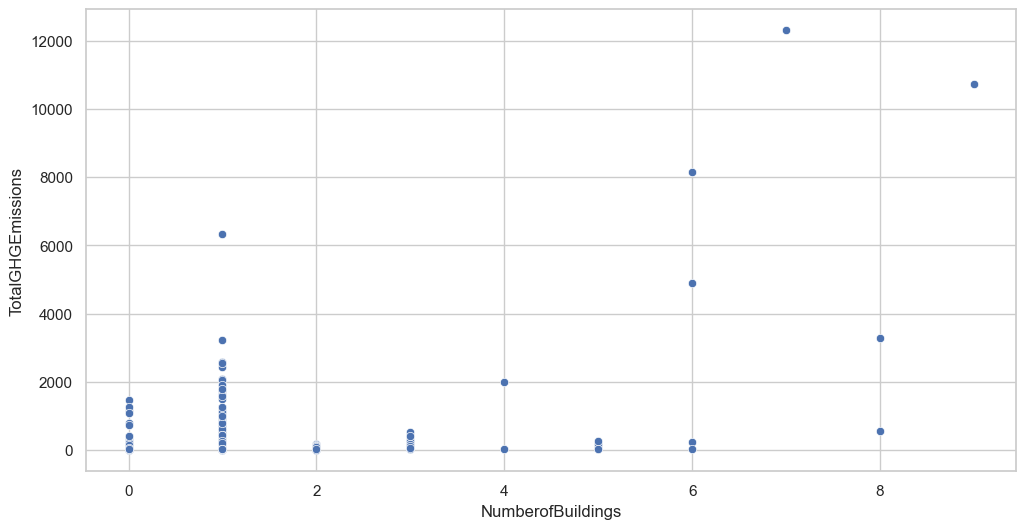

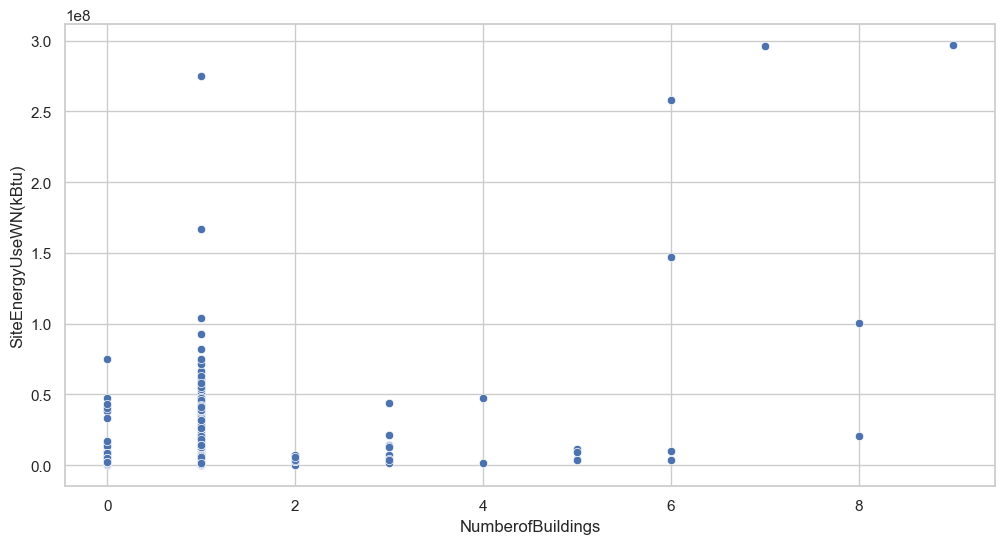

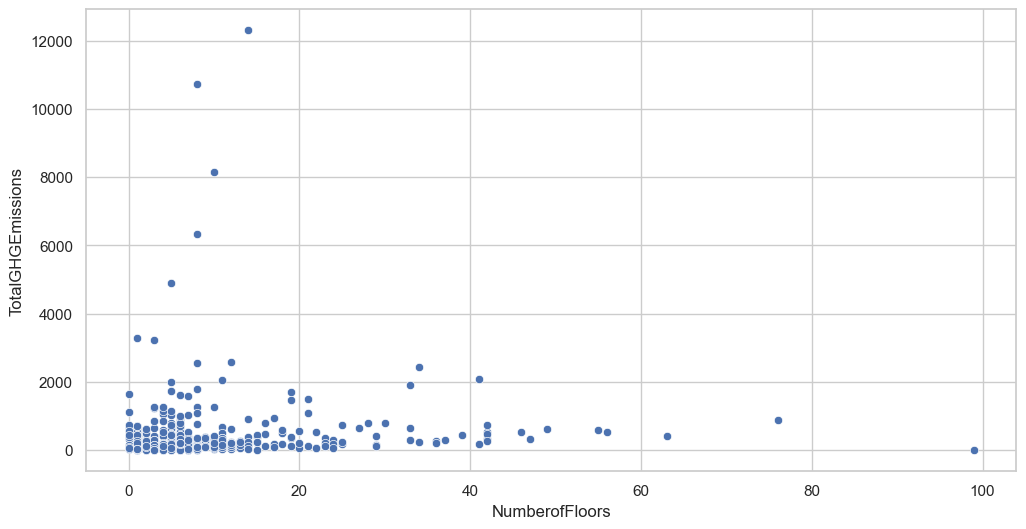

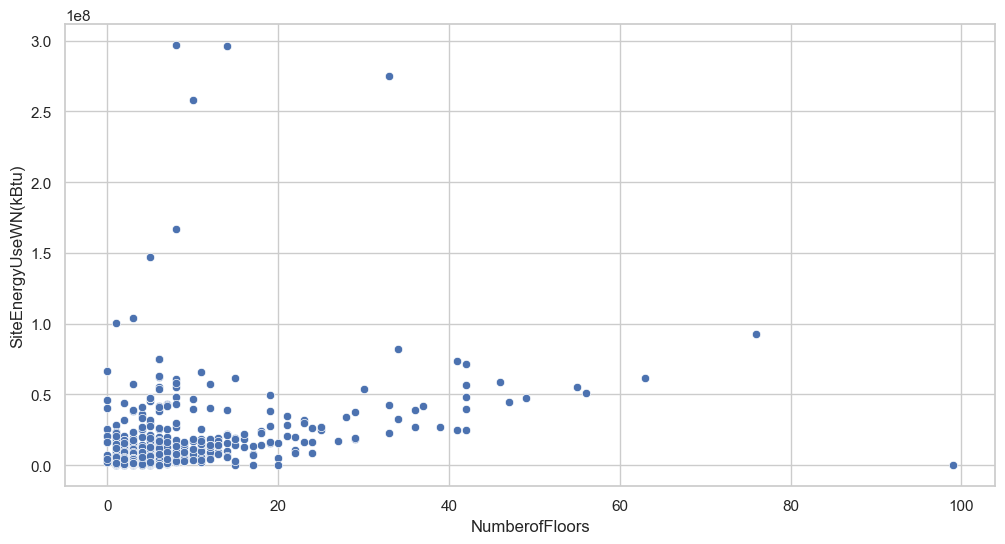

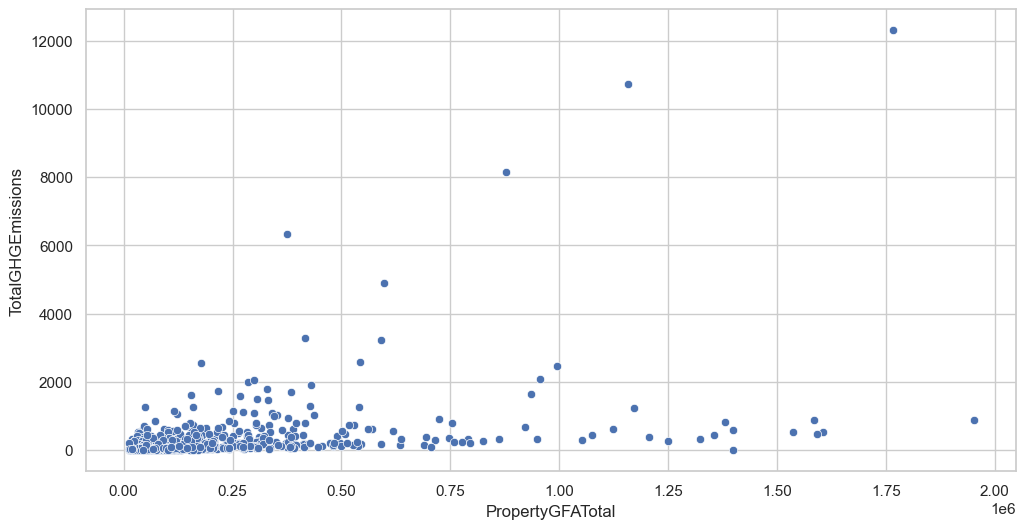

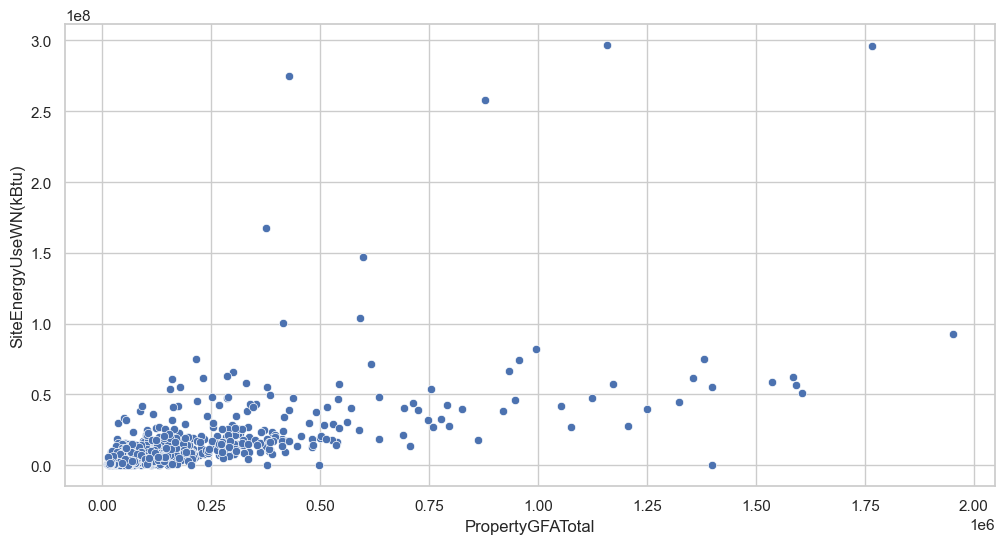

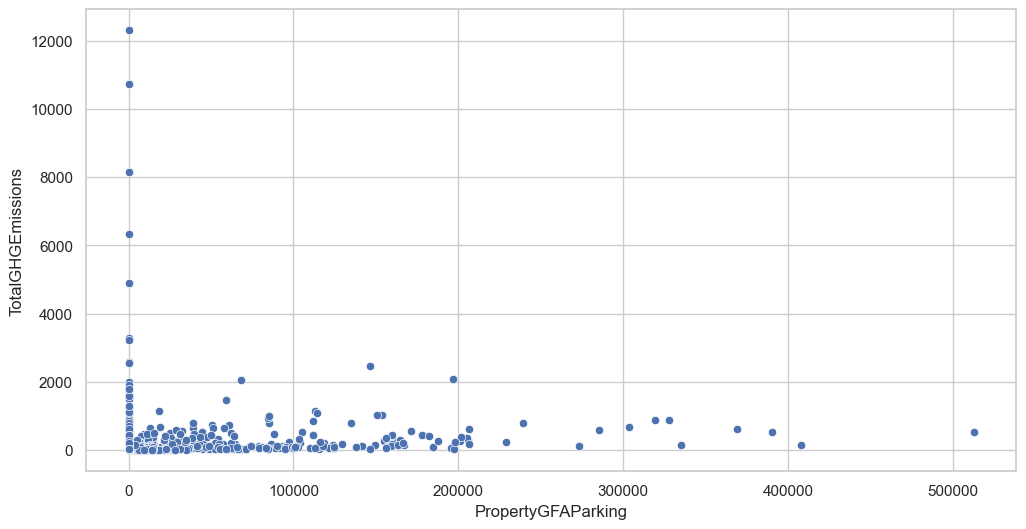

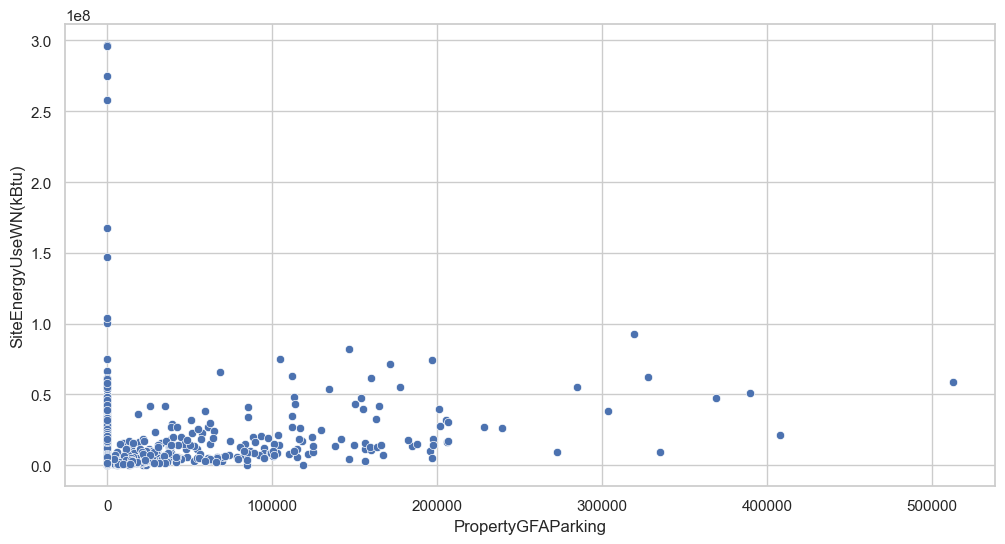

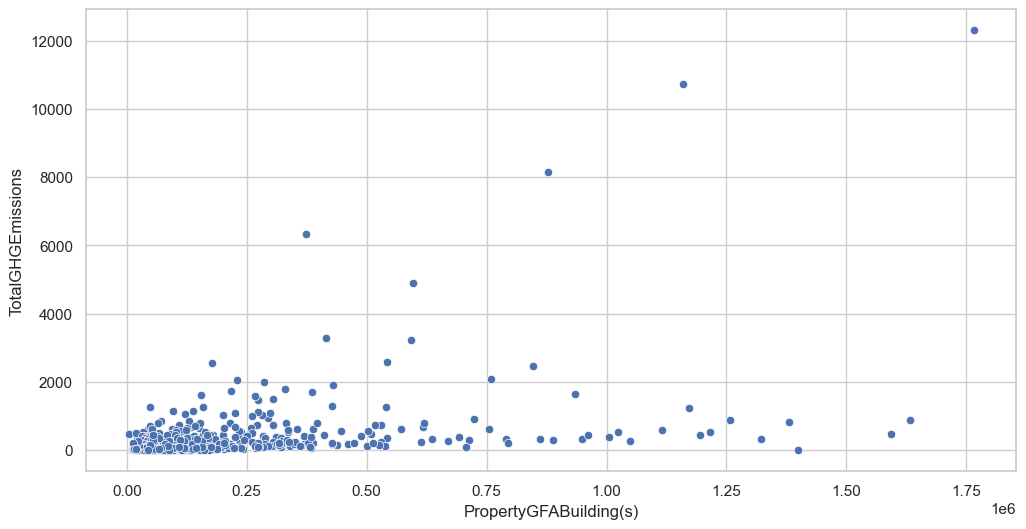

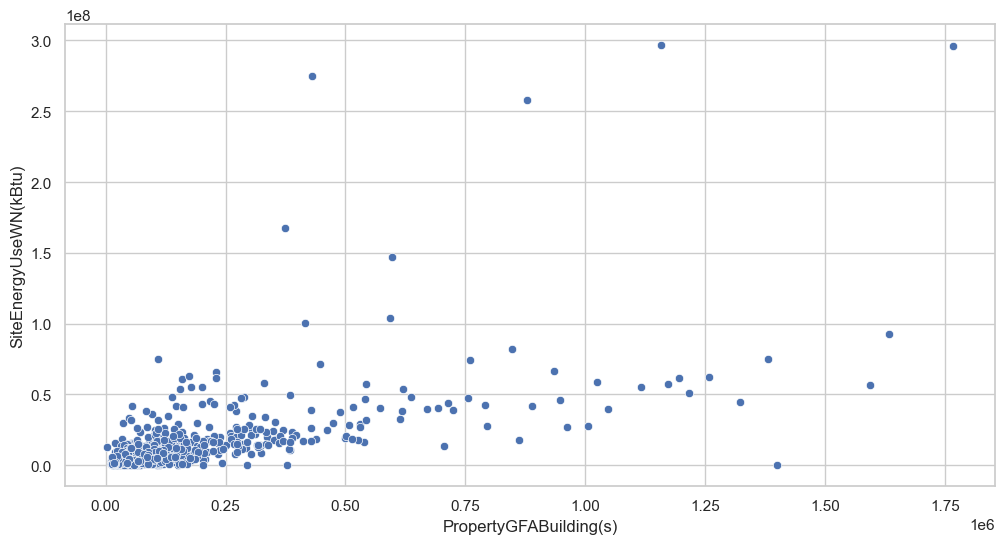

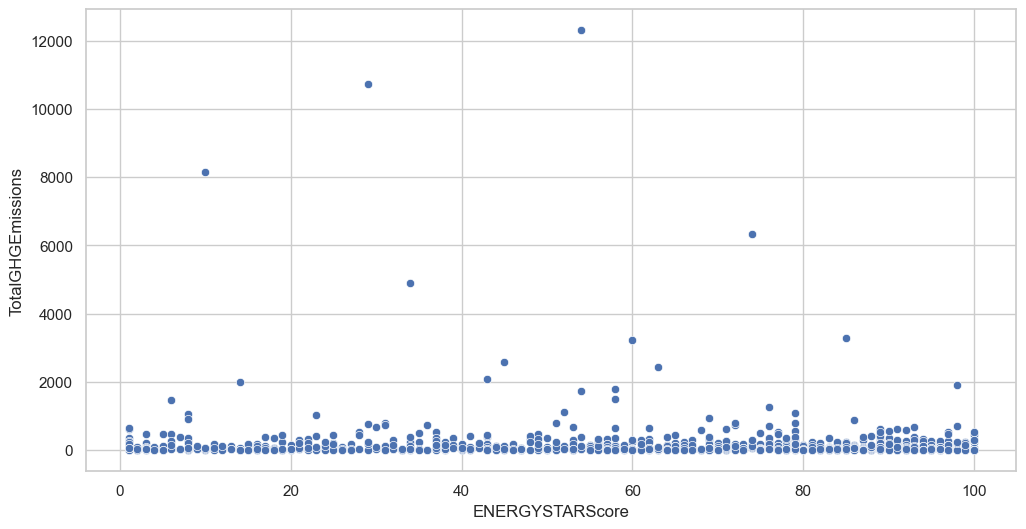

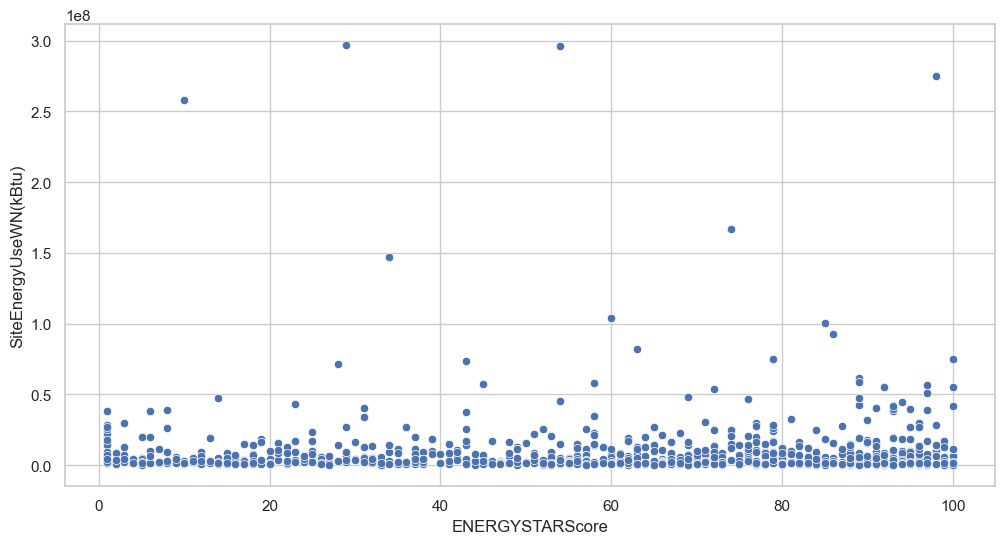

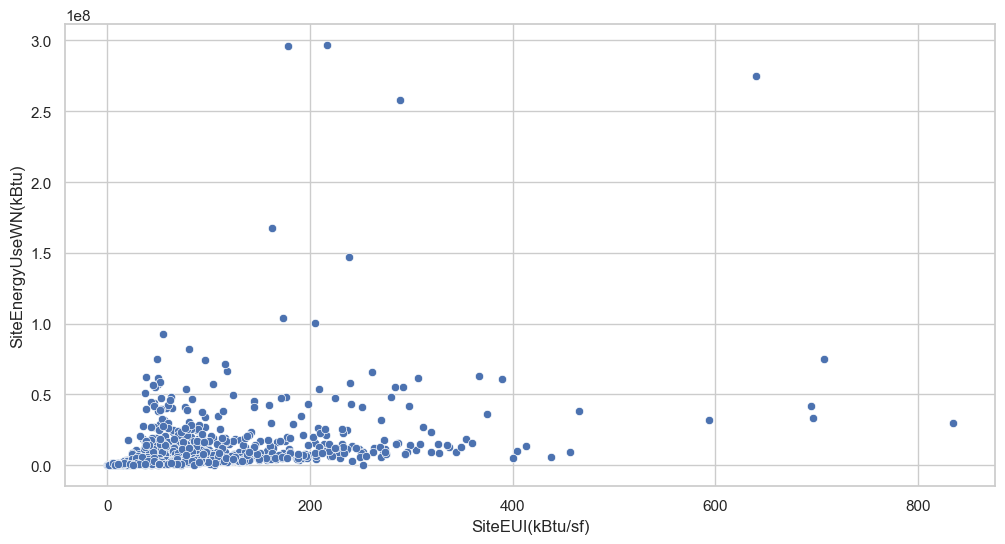

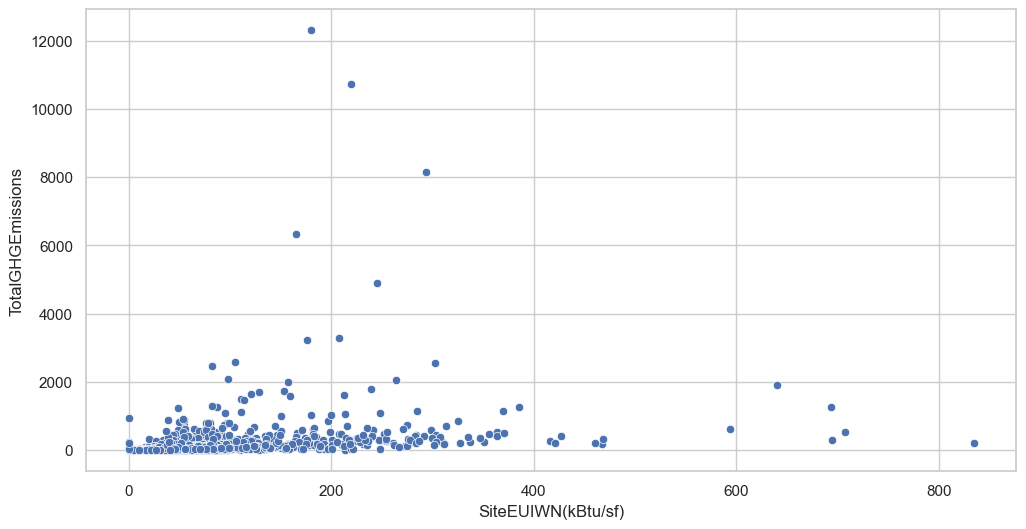

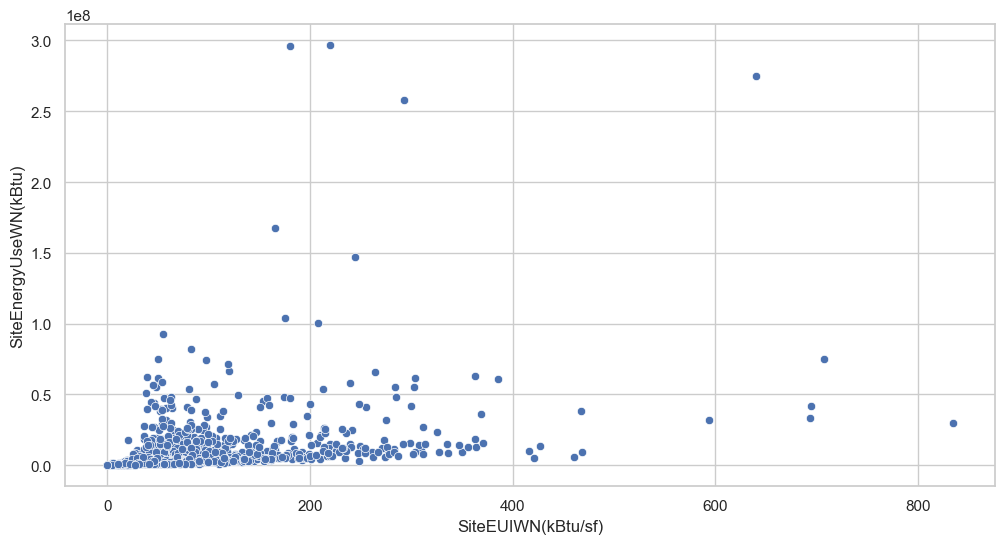

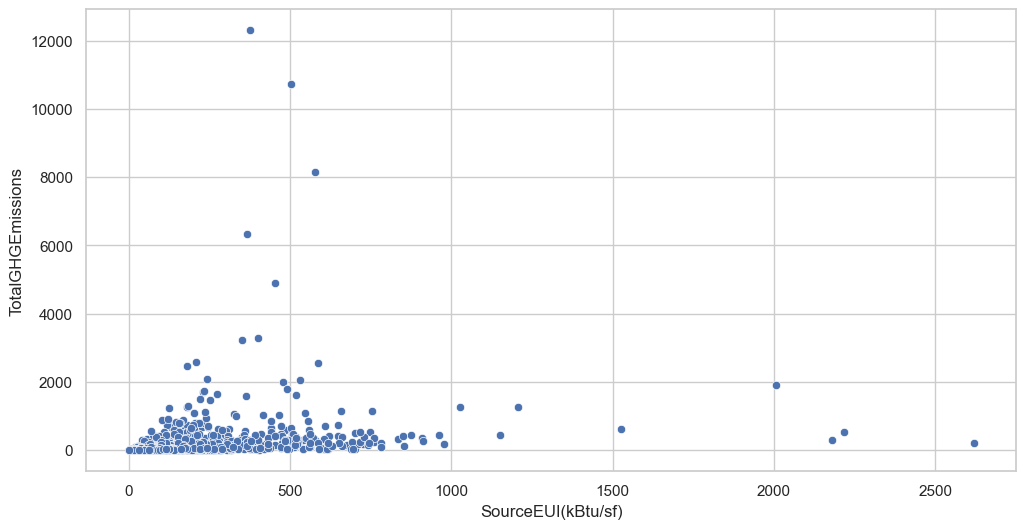

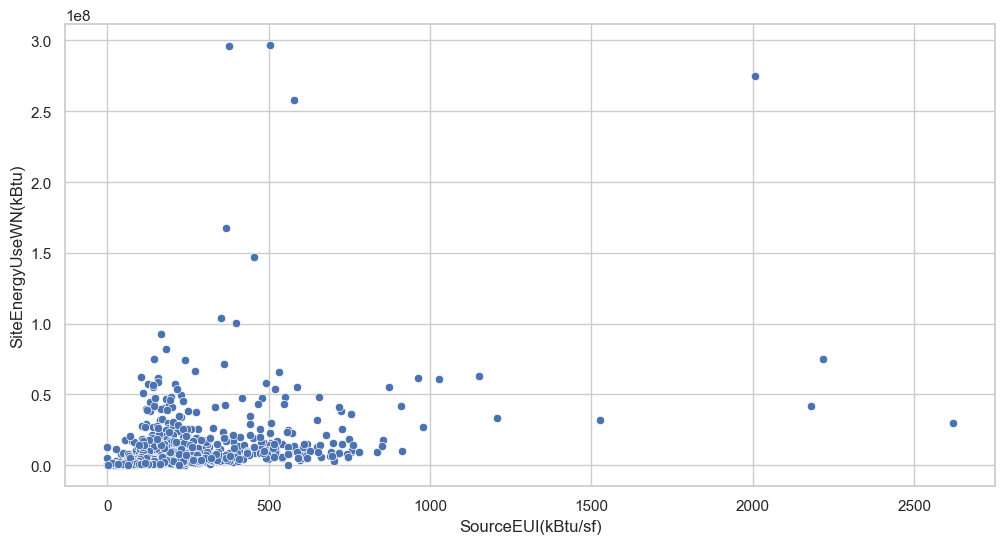

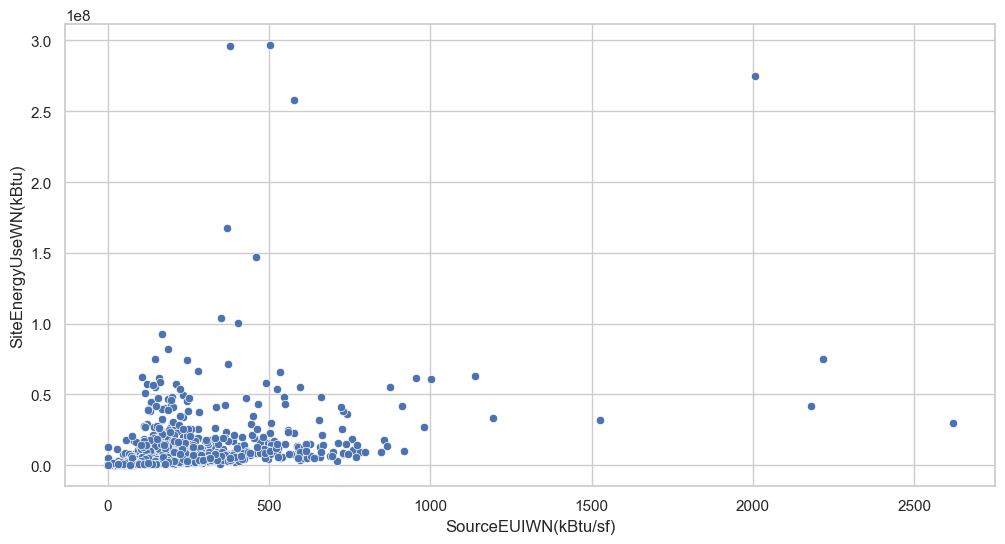

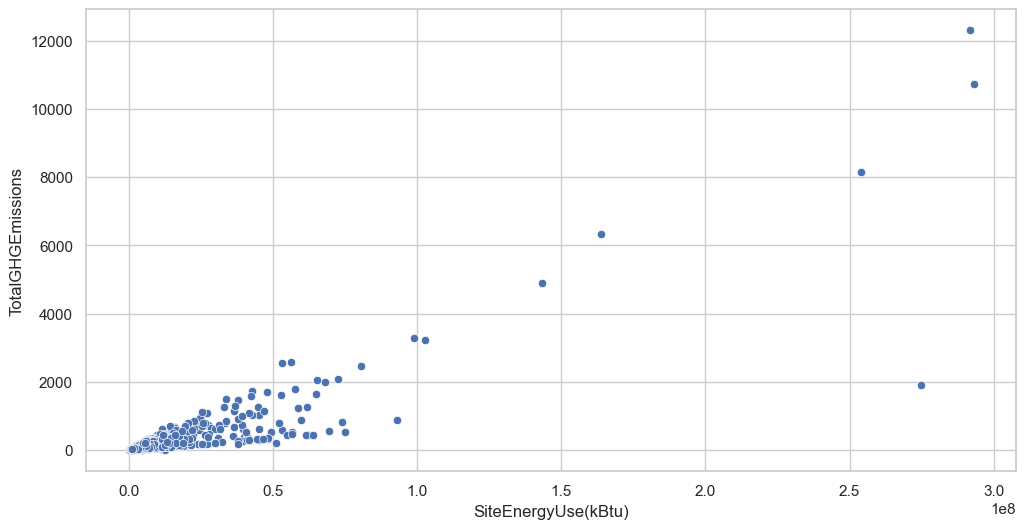

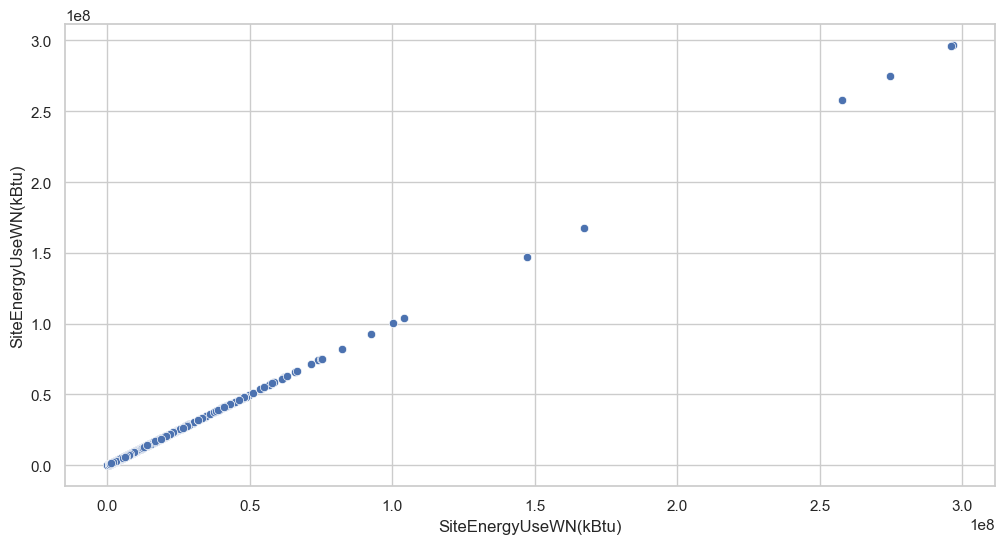

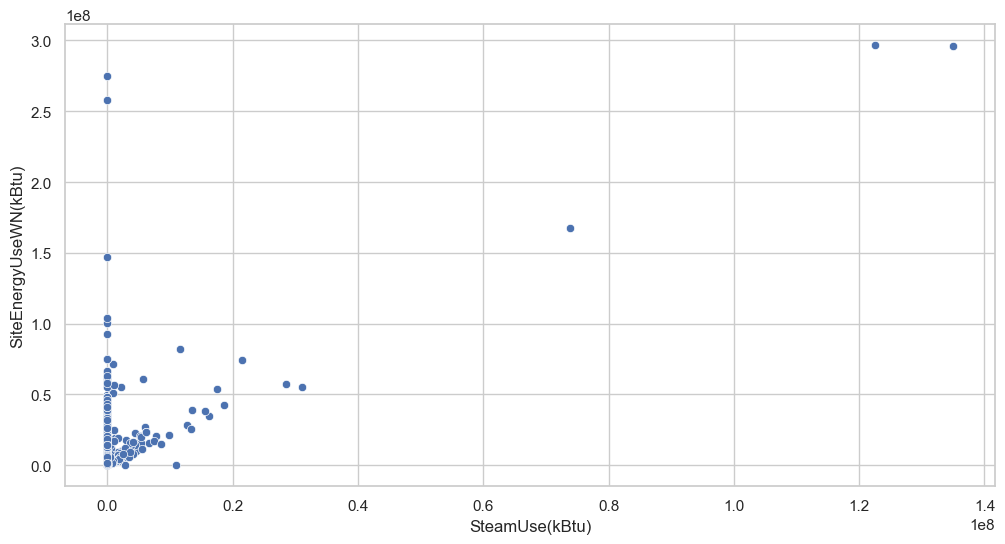

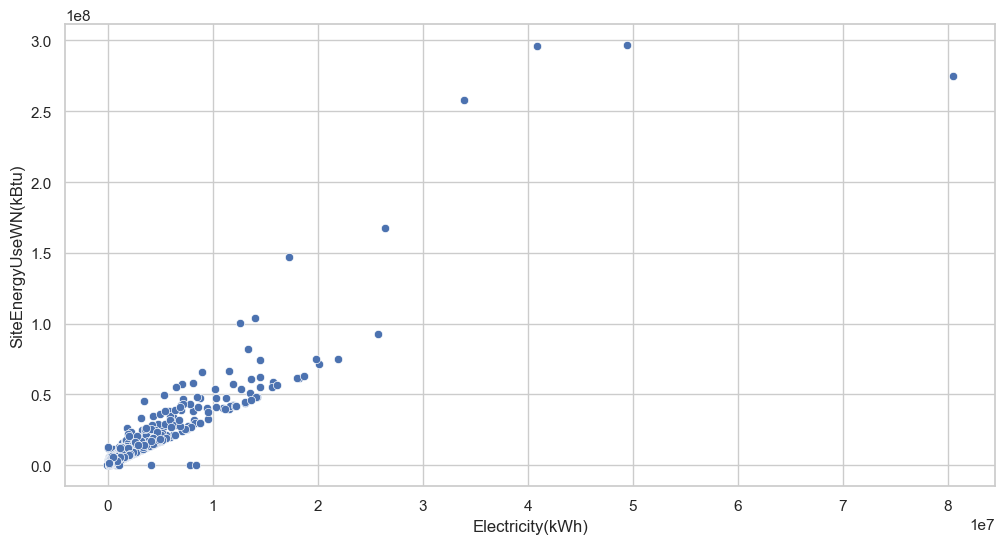

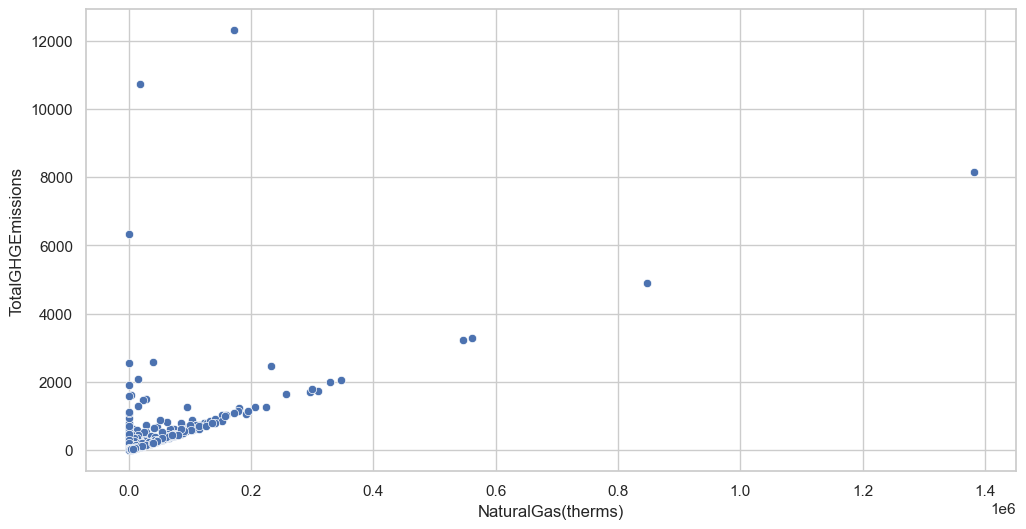

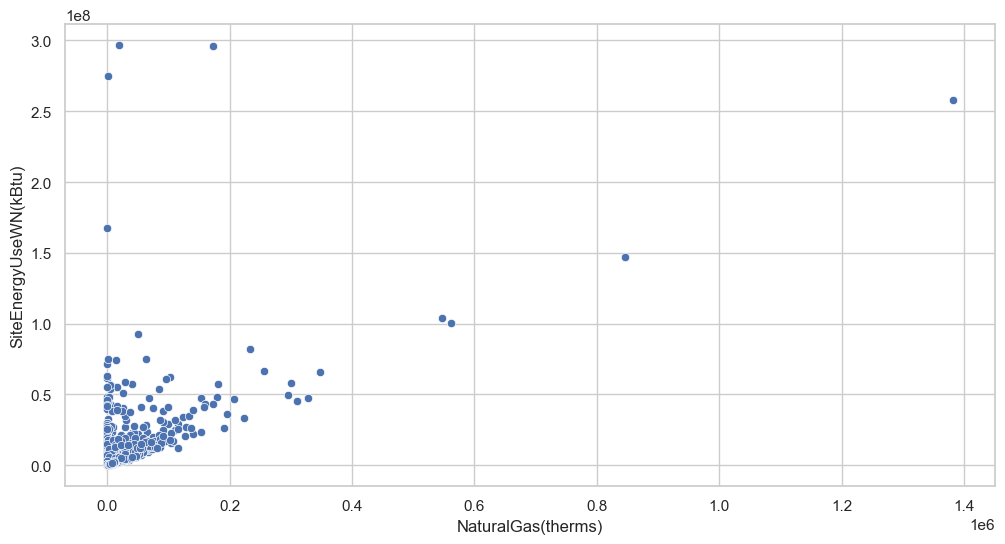

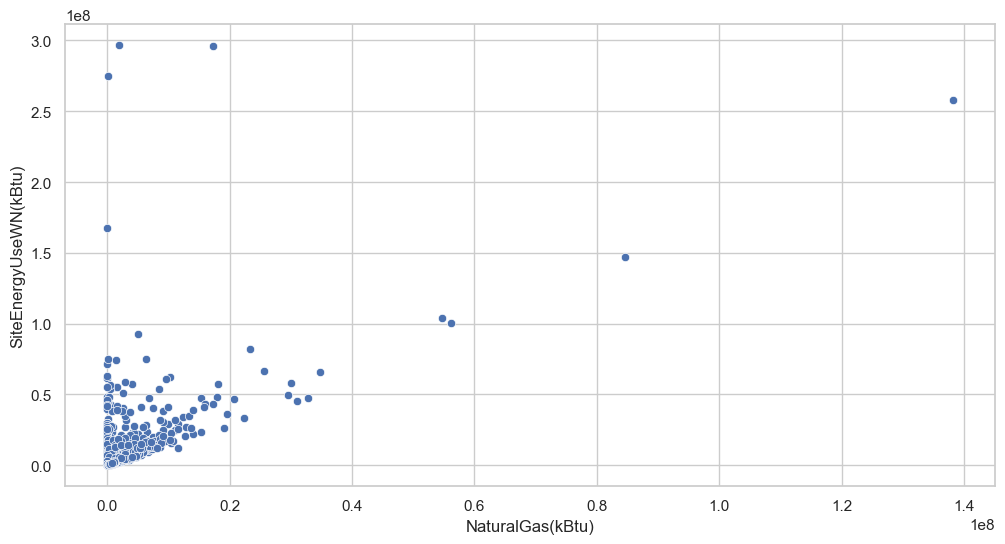

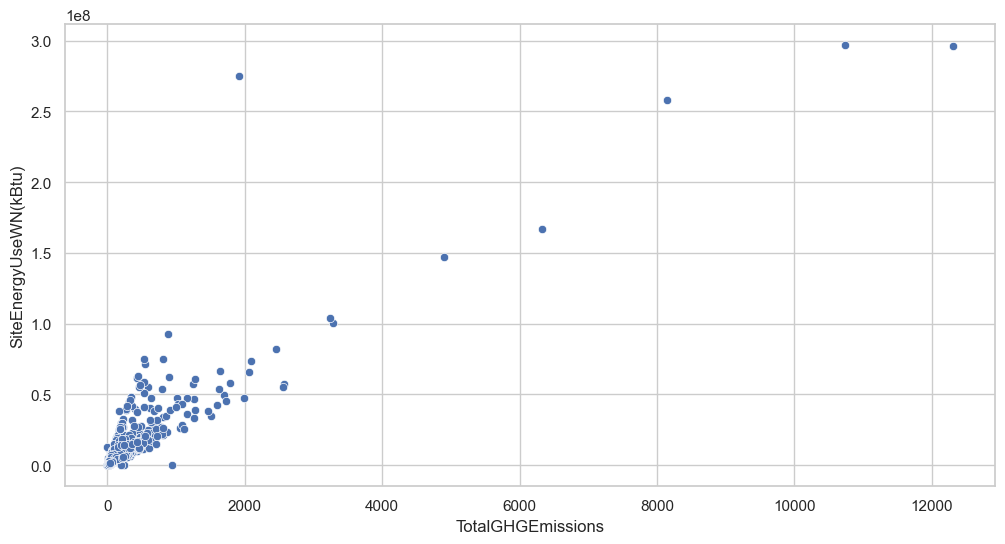

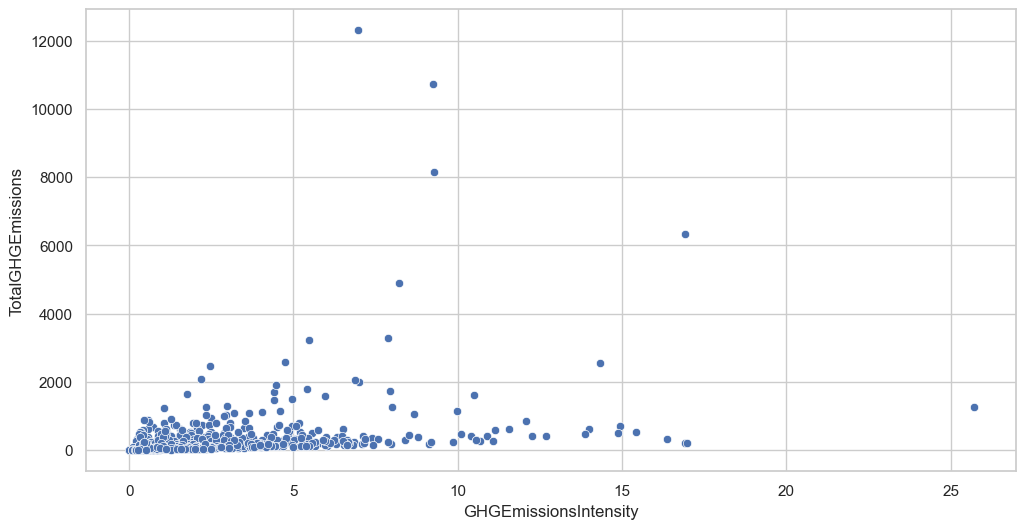

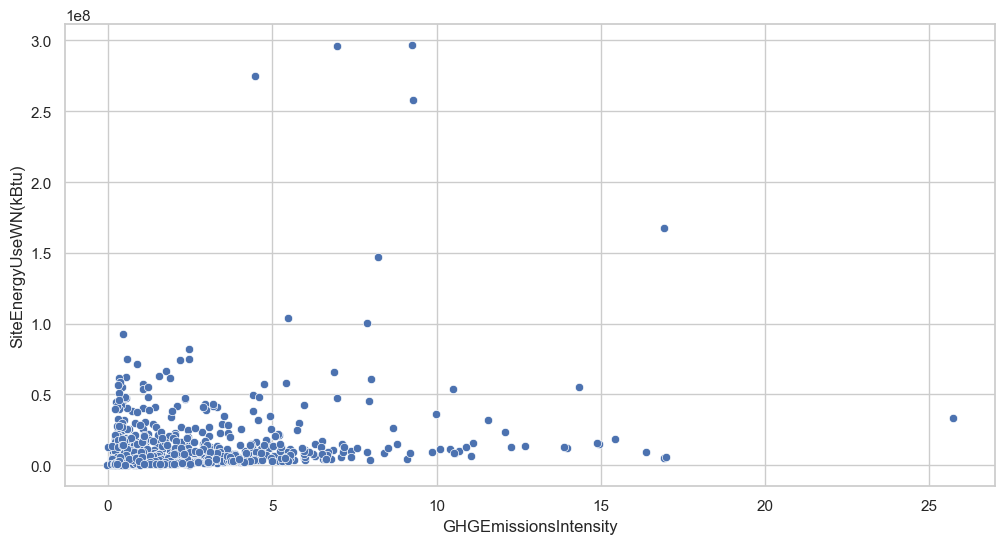

In [26]:
# Créer le pairplot avec une variable catégorielle pour colorer les points avec hue
for col in df_seatle_NR.select_dtypes(exclude='object'):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data= df_seatle_NR, y='TotalGHGEmissions', x= col)
    plt.show()
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data= df_seatle_NR, y='SiteEnergyUseWN(kBtu)', x= col)
    plt.show()

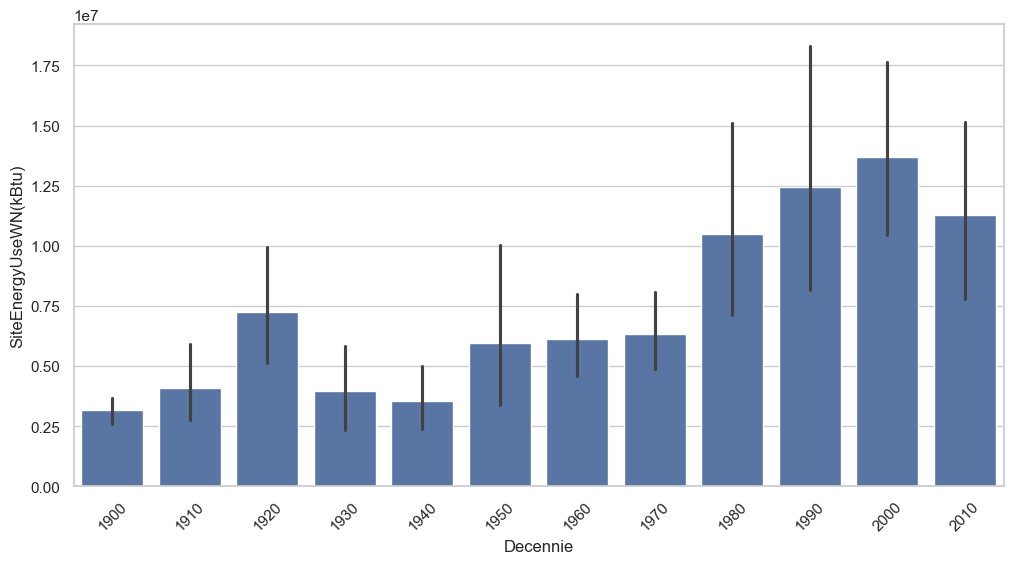

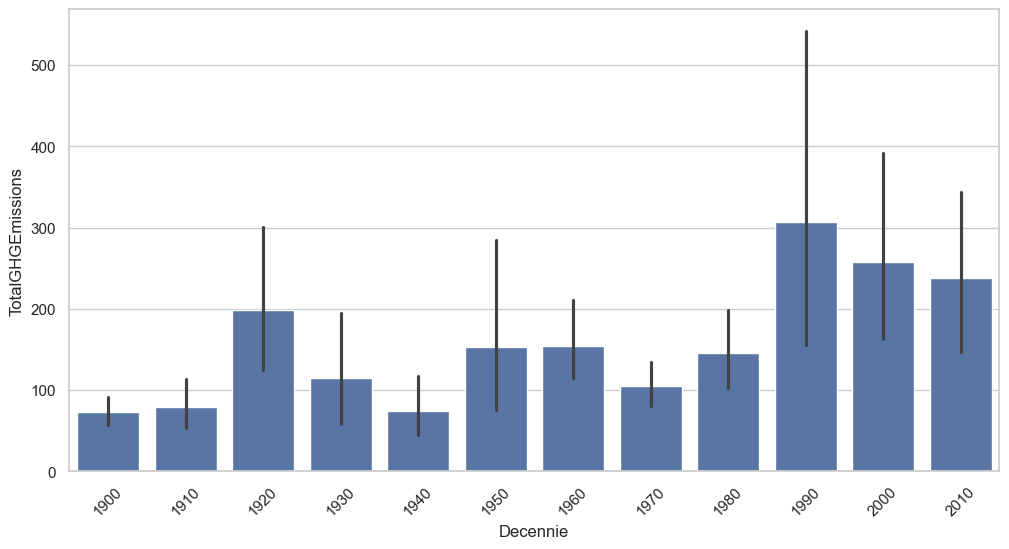

In [49]:
# Etude des consommation des batiments en fonction de leur année de construction
df_seatle_NR['Decennie'] = (df_seatle_NR['YearBuilt'] // 10) * 10  # Regroupe par décennie

plt.figure(figsize=(12, 6))
# sns.boxplot(x='Decennie', y='SiteEnergyUseWN(kBtu)', data=df_seatle_NR)
sns.barplot(x='Decennie', y='SiteEnergyUseWN(kBtu)', data=df_seatle_NR)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='Decennie', y='TotalGHGEmissions', data=df_seatle_NR)
plt.xticks(rotation=45)
plt.show()

In [28]:
if 'Decennie' in df_seatle_NR.columns:
    df_seatle_NR = df_seatle_NR.drop(columns='Decennie')

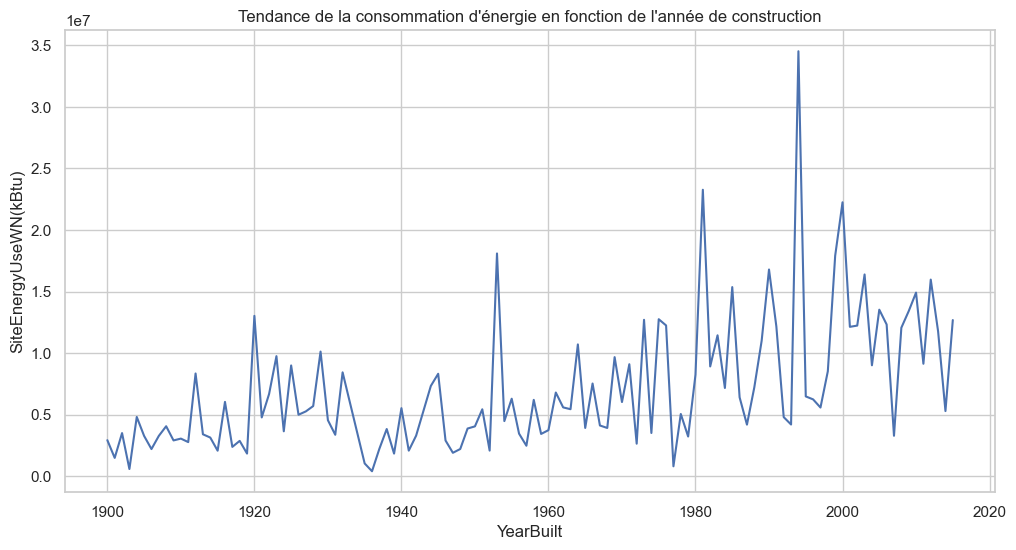

In [53]:
# Essayons avec une autre methode ( nous voyons la variation de la consommation en fonction des années de construction des bâtiments)
df_grouped = df_seatle_NR.groupby('YearBuilt')['SiteEnergyUseWN(kBtu)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='YearBuilt', y='SiteEnergyUseWN(kBtu)', data=df_grouped)
plt.title("Tendance de la consommation d'énergie en fonction de l'année de construction")
plt.show()

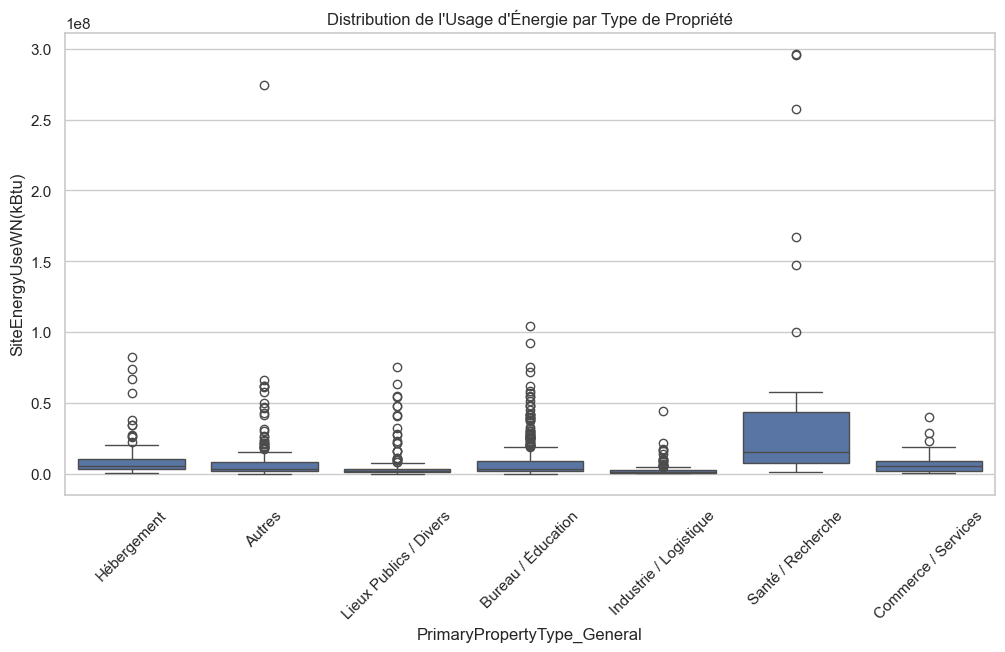

In [55]:
# Etudes des relation entre ma nouvelle variable catégorielle et mes cibles
plt.figure(figsize=(12, 6))
sns.boxplot(x='PrimaryPropertyType_General', y='SiteEnergyUseWN(kBtu)', data=df_seatle_NR)
plt.xticks(rotation=45)  # Faire pivoter les labels pour une meilleure lisibilité
plt.title("Distribution de l'Usage d'Énergie par Type de Propriété")
plt.show()

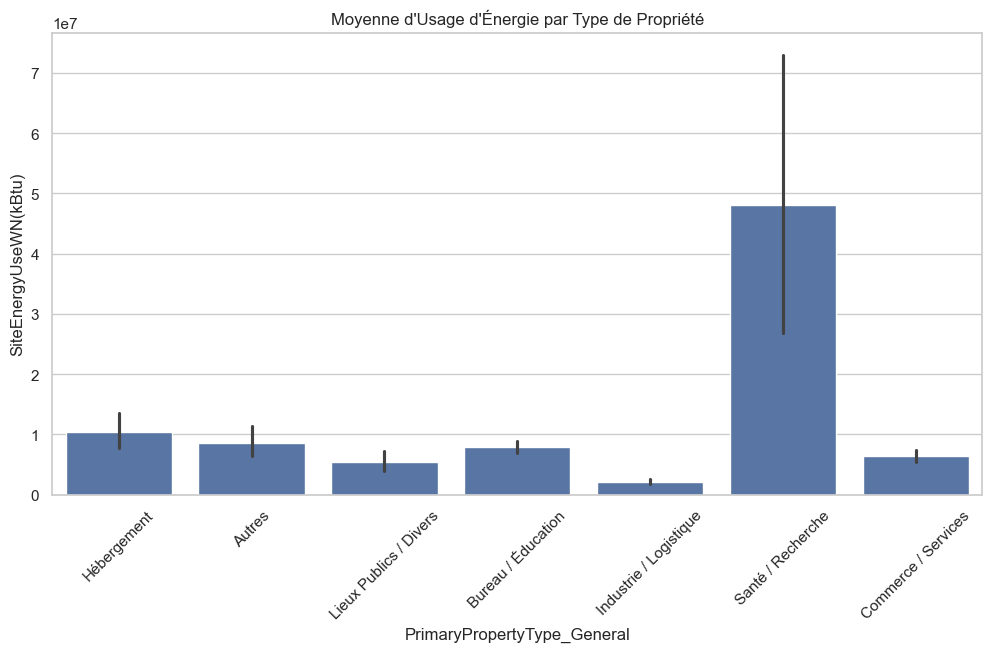

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x='PrimaryPropertyType_General', y='SiteEnergyUseWN(kBtu)', data=df_seatle_NR)
plt.xticks(rotation=45)
plt.title("Moyenne d'Usage d'Énergie par Type de Propriété")
plt.show()

## Analyse Variables / Variables

In [30]:
numeric_var = df_seatle_NR.select_dtypes(exclude = 'object').columns

<Axes: >

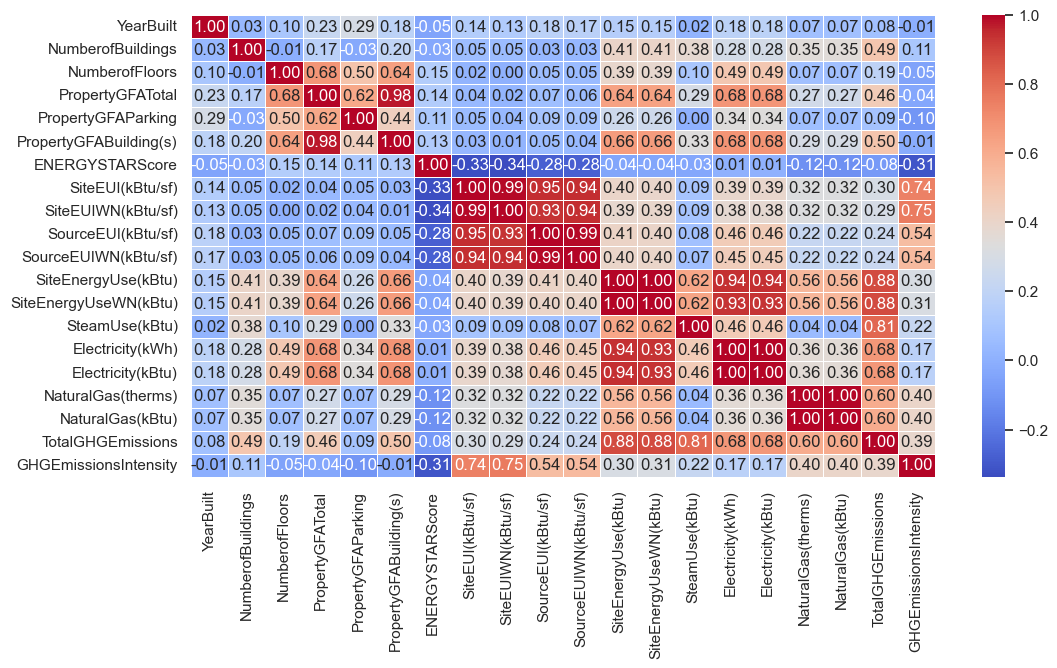

In [32]:
plt.figure(figsize = (12,6))
sns.heatmap(df_seatle_NR[numeric_var].corr(), annot = True,fmt='.2f', linewidths = .5, cmap='coolwarm')

In [34]:
# Liste des variables redondante a supprimer car très corrélées entre elle (même info mais a des unités differents)
vars_to_drop = [
    'PropertyGFABuilding(s)',
    'SiteEnergyUse(kBtu)',   # Cibles et fuites de données
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'PropertyGFATotal', # PropertyGFATotal = PropertyGFABuildings + PropertyGFAParking
    'GHGEmissionsIntensity'  # Potentiellement redondante avec `TotalGHGEmissions`
]

In [36]:
df_seatle_NR = df_seatle_NR.drop(columns = vars_to_drop)

<Axes: >

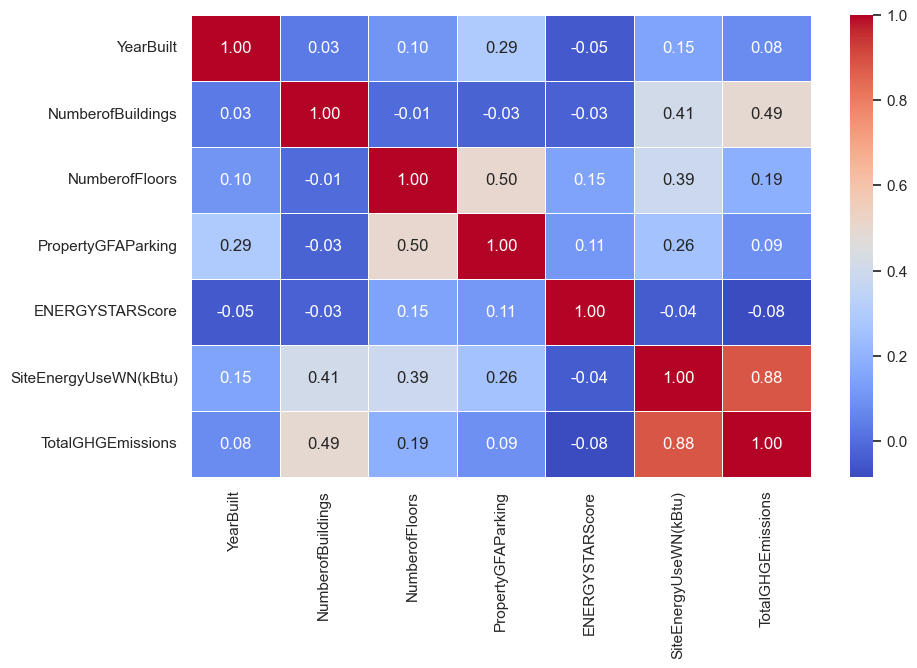

In [38]:
numeric_var = df_seatle_NR.select_dtypes(exclude = 'object').columns
plt.figure(figsize = (10,6))
sns.heatmap(df_seatle_NR[numeric_var].corr(), annot = True,fmt='.2f', linewidths = .5, cmap='coolwarm')

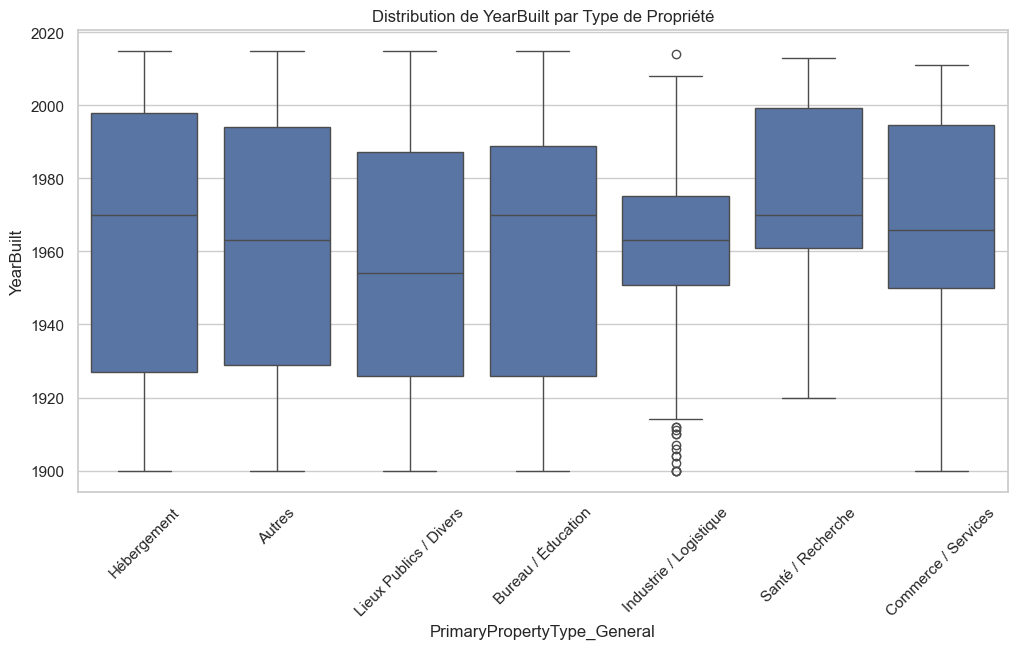

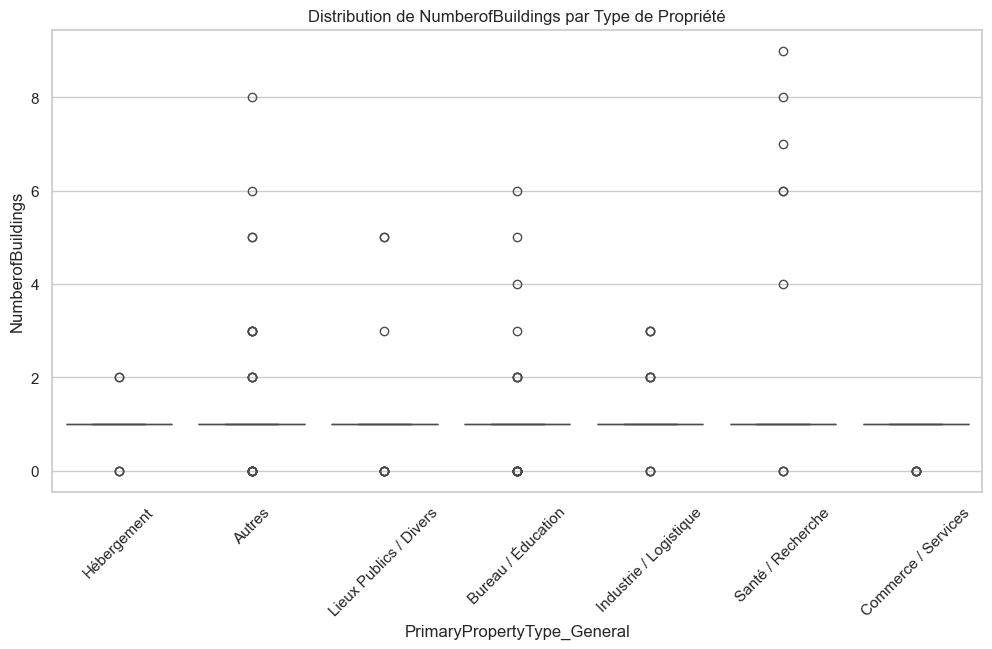

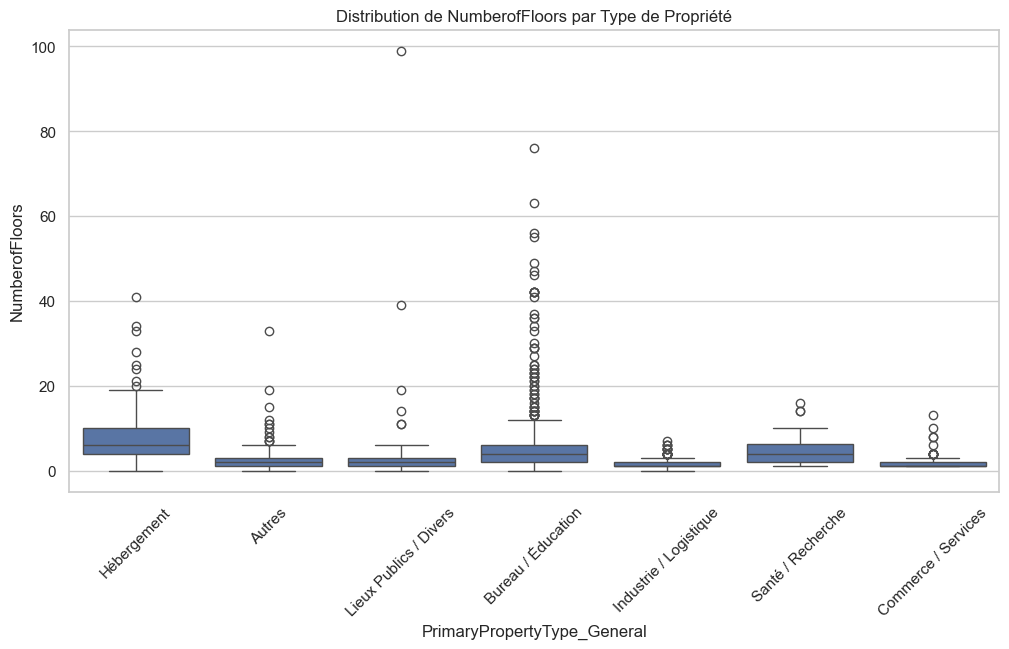

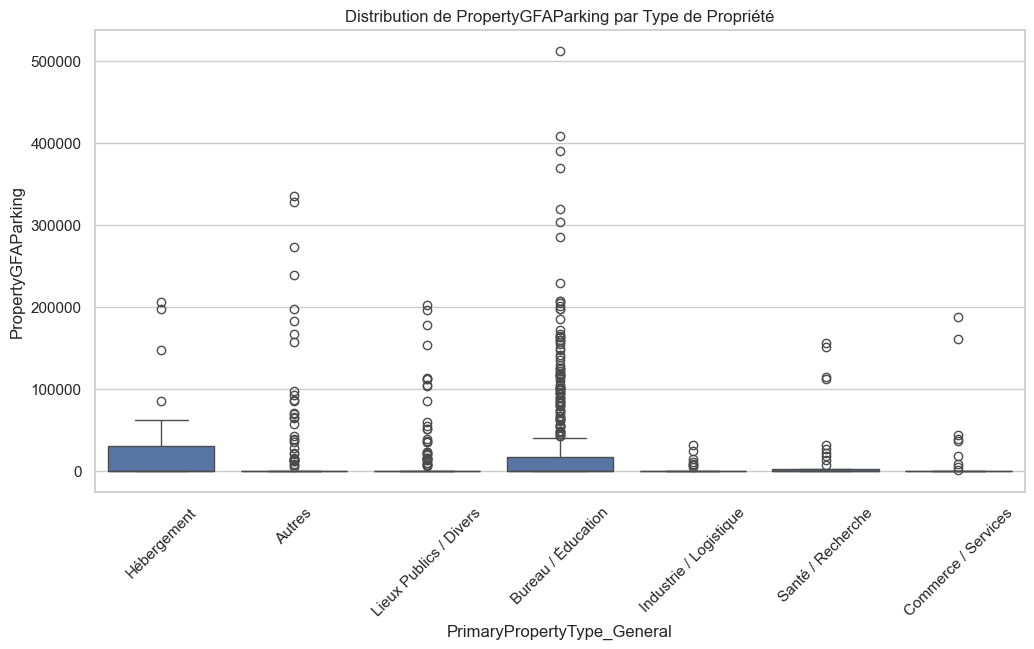

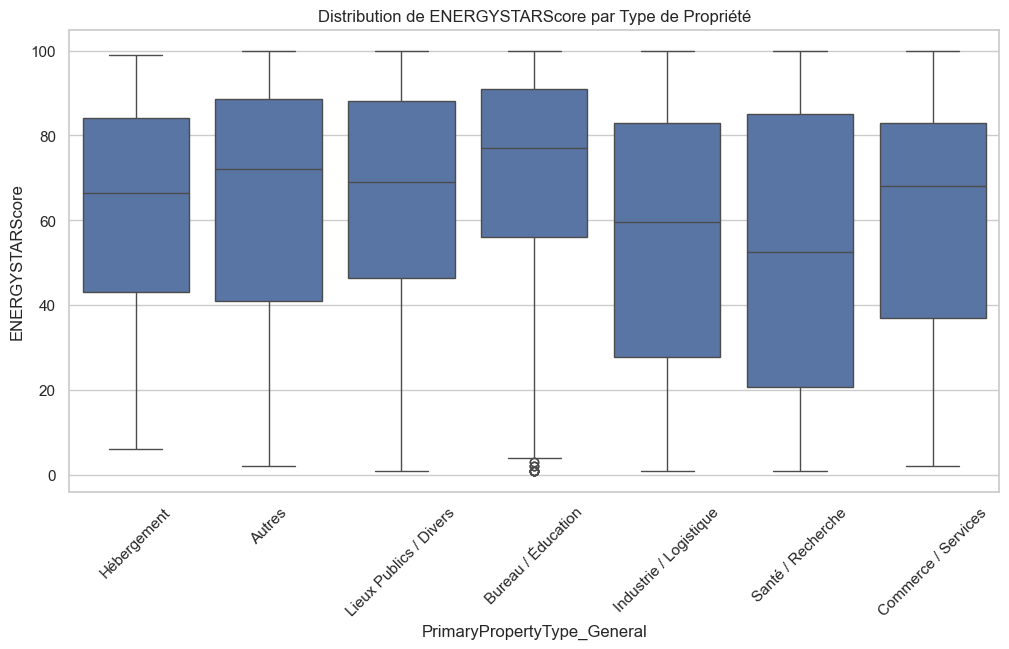

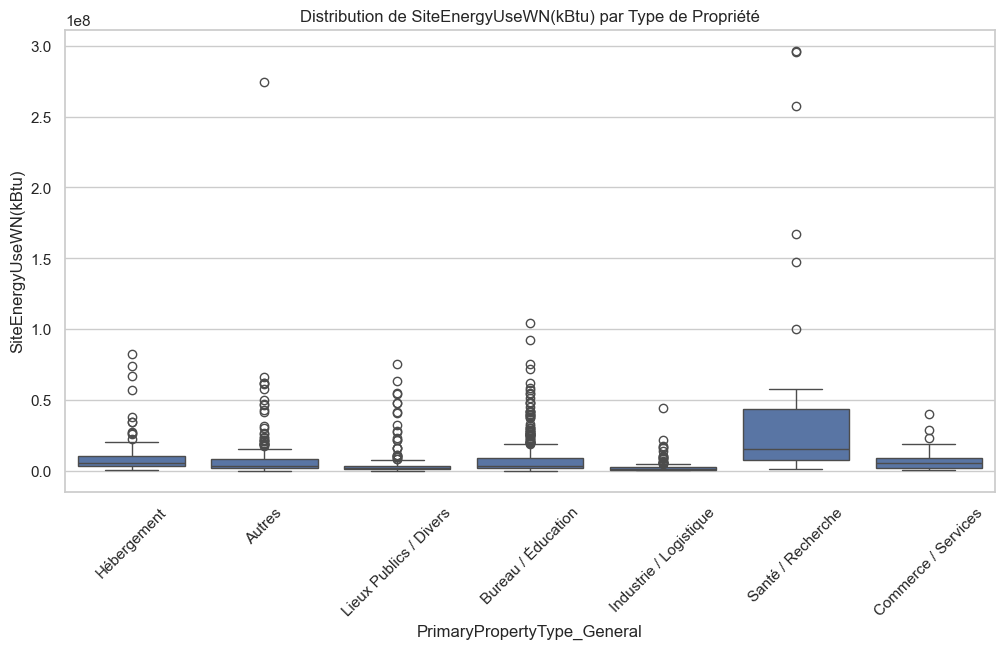

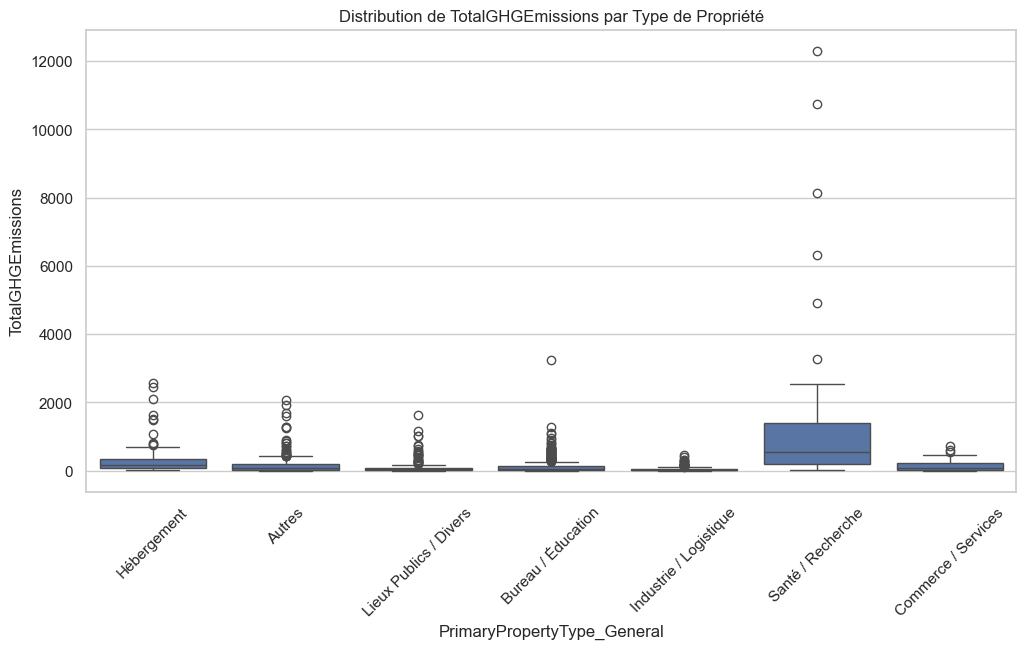

In [40]:
# Variable categorielle et variable numeric
if 'ListOfAllPropertyUseTypes' in df_seatle_NR.columns:
    df_seatle_NR = df_seatle_NR.drop(columns='ListOfAllPropertyUseTypes')
for col in numeric_var:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='PrimaryPropertyType_General', y=col, data=df_seatle_NR)
    plt.xticks(rotation=45)  # Faire pivoter les labels pour une meilleure lisibilité
    plt.title("Distribution de "+col+" par Type de Propriété")
    plt.show()

In [40]:
# faisons un test ANOVA entre ma variable categorielle et mes cibles
# Comparer les émissions de CO2 selon le type de bâtiment
from scipy.stats import f_oneway

for var in numeric_var:
    groups = [df_seatle_NR[df_seatle_NR['PrimaryPropertyType_General'] == cat][var] for cat in df_seatle_NR['PrimaryPropertyType_General'].unique()]
    anova_result = f_oneway(*groups)
    
    print('Pour la Variable', var, '\n')
    if (anova_result.pvalue > 0.05):
        print(f"La catégorie n'a pas d'impact significatif car p_value = {anova_result.pvalue} et F-statistic: {anova_result.statistic}")
    else:
        print(f"La catégorie influence significativement car p_value = {anova_result.pvalue} et F-statistic: {anova_result.statistic}")
    print('_'*100)

Pour la Variable YearBuilt 

La catégorie influence significativement car p_value = 0.011026460933025735 et F-statistic: 2.771983465346315
____________________________________________________________________________________________________
Pour la Variable NumberofBuildings 

La catégorie influence significativement car p_value = 1.8519572561730815e-14 et F-statistic: 13.061893041294597
____________________________________________________________________________________________________
Pour la Variable NumberofFloors 

La catégorie influence significativement car p_value = 9.046012516066293e-34 et F-statistic: 29.654088625494236
____________________________________________________________________________________________________
Pour la Variable PropertyGFAParking 

La catégorie influence significativement car p_value = 1.2264250814069768e-12 et F-statistic: 11.515507522620005
____________________________________________________________________________________________________
Pour la Va

# 2 - Pre-processing 

## Objectif: transformer le data pour le mettre dans un format propice au machine learning ( un random_state = 0, pour pouvoir leur comparer sur la même base)

- **Encodage** :
    - Modèle linéaire (Régression linéaire, Lasso, Ridge, SVM) → One-Hot Encoding
    - Modèle basé sur des arbres (Random Forest, XGBoost, LightGBM) → Target Encoding
- **Select KBest** : j'obtient un meilleur score avec toutes mes variables.

## MultiOutputRegressor
- **Modèle** :
    - **Linéaires**:
          - LinearRegression avec des perf : RMSE : 6582354.360535262, MAE : 2476084.6944704806, R² : -0.015576419818499776
          - Ridge : RMSE : 6580525.366034379, MAE : 2475775.444873329, R² : -0.01490960863885421
          - Lasso : RMSE : 6582353.9613247225, MAE : 2476084.464733687, R² : -0.013257604961256442
- **Metrics** : Une grosse erreur sur les valeurs de prediction peut être problématique pour la prise de décision (ex. sous-estimer la consommation d’un bâtiment pourrait conduire à une mauvaise planification énergétique).
Comme la RMSE pénalise fortement les grosses erreurs, elle garantit que mon modèle ne fait pas d’erreurs trop importantes sur certains bâtiments.


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

In [44]:
trainset, testset = train_test_split(df_seatle_NR, test_size = 0.2, random_state=0)
testset.shape

(309, 8)

In [46]:
# encoder mes categories
'''def encodage_target_encoder(df):
    df = df.copy()  # Éviter de modifier l'original
    
    encoder = TargetEncoder(cols=['PrimaryPropertyType_General'])
    df['PrimaryPropertyType_General'] = encoder.fit_transform(df['PrimaryPropertyType_General'], df['SiteEnergyUseWN(kBtu)'])
    return df'''

'''def encodage_one_hot(df): #target= 'TotalGHGEmissions',  enc_type_tree=True,) :
    # Modèle linéaire (Régression linéaire, Lasso, Ridge, SVM) → One-Hot Encoding
    # Modèle basé sur des arbres (Random Forest, XGBoost, LightGBM) → Target Encoding
    
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' pour éviter la colinéarité
    encoded_array = encoder.fit_transform(df[['PrimaryPropertyType_General']])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['PrimaryPropertyType_General']))
    
    # Fusionner avec le DataFrame original et supprimer la colonne catégorielle
    df = pd.concat([df.drop(columns=['PrimaryPropertyType_General']), encoded_df], axis=1)

    return df'''

"def encodage_one_hot(df): #target= 'TotalGHGEmissions',  enc_type_tree=True,) :\n    # Modèle linéaire (Régression linéaire, Lasso, Ridge, SVM) → One-Hot Encoding\n    # Modèle basé sur des arbres (Random Forest, XGBoost, LightGBM) → Target Encoding\n    \n    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' pour éviter la colinéarité\n    encoded_array = encoder.fit_transform(df[['PrimaryPropertyType_General']])\n    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['PrimaryPropertyType_General']))\n    \n    # Fusionner avec le DataFrame original et supprimer la colonne catégorielle\n    df = pd.concat([df.drop(columns=['PrimaryPropertyType_General']), encoded_df], axis=1)\n\n    return df"

 et si j'encodais mes données et je fais du KNN et je revien sur mon encode one hot puis 

In [49]:
# Imputation des NaN avec KNNimputer (faire après un gridSearchCV pour améliorer n_neigbors)
def imputation(df):
    imputer = KNNImputer(n_neighbors=10) # après un gridSearchCV n_neighbors optimal est 10
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    print(df_imputed.isna().sum())
    return df_imputed


def preprocessing(df):
    # Et si je faisais le log des cibles
    df['TotalGHGEmissions'] = np.log1p(df['TotalGHGEmissions'])
    #df['SiteEnergyUseWN(kBtu)'] = np.log1p(df['SiteEnergyUseWN(kBtu)'])
    
    X = df.drop(columns=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'])
    y = df[ 'TotalGHGEmissions'] # 'SiteEnergyUseWN(kBtu)'
    
    return X, y


In [51]:
# Appliquer preprocessing
encoder = TargetEncoder(cols=['PrimaryPropertyType_General'])
trainset['PrimaryPropertyType_General'] = encoder.fit_transform(trainset['PrimaryPropertyType_General'], trainset['TotalGHGEmissions'])
testset['PrimaryPropertyType_General'] = encoder.transform(testset['PrimaryPropertyType_General'])  # Pas de fit !

trainset_imputed = imputation(trainset)
testset_imputed = imputation(testset)

trainset_imputed.drop(columns=['PrimaryPropertyType_General'], inplace=True)
testset_imputed.drop(columns=['PrimaryPropertyType_General'], inplace=True)

YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFAParking             0
ENERGYSTARScore                0
SiteEnergyUseWN(kBtu)          0
TotalGHGEmissions              0
PrimaryPropertyType_General    0
dtype: int64
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFAParking             0
ENERGYSTARScore                0
SiteEnergyUseWN(kBtu)          0
TotalGHGEmissions              0
PrimaryPropertyType_General    0
dtype: int64


In [53]:
encoder_ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded_train = encoder_ohe.fit_transform(trainset[['PrimaryPropertyType_General']])
encoded_test = encoder_ohe.transform(testset[['PrimaryPropertyType_General']])

# Convertir en DataFrame et fusionner avec le dataset original
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder_ohe.get_feature_names_out(['PrimaryPropertyType_General']))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder_ohe.get_feature_names_out(['PrimaryPropertyType_General']))

trainset_final = pd.concat([trainset_imputed, encoded_train_df], axis=1)
testset_final = pd.concat([testset_imputed, encoded_test_df], axis=1)

X_train, y_train = preprocessing(trainset_final)
X_test, y_test = preprocessing(testset_final)


### Modelisation

In [56]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve

In [58]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures

In [62]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    
    print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("R² :", r2_score(y_test, y_pred))

    N, train_score, val_score = learning_curve(model, X_train, 
                                               y_train, cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 6))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

In [64]:
import warnings
# Filtrer les avertissements spécifiques de LightGBM
warnings.filterwarnings("ignore", category=UserWarning)

In [63]:
# polynomiale feature aussi est intéressant
#model_1 = RegressorChain(RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0))
#model_2 = RegressorChain(xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0))
#model_3 = RegressorChain(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=0, verbosity=0))
#model_4 = RegressorChain(SVR(kernel='linear', C=100, gamma=0.1)) #, random_state=0))
#model_5 = RegressorChain(KNeighborsRegressor(n_neighbors=5))

In [65]:
#evaluation(model_5)

[RandomForestRegressor(max_depth=10, random_state=0), RandomForestRegressor(max_depth=10, random_state=0)]


<Axes: >

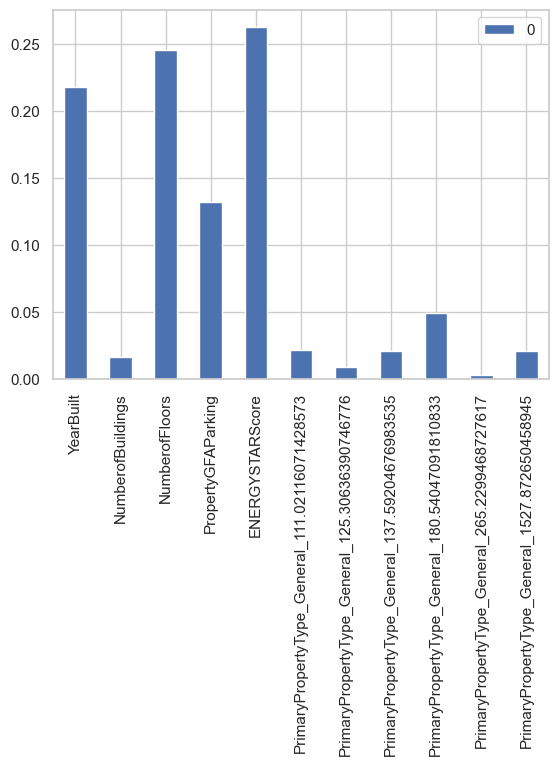

In [413]:
# Vérifier les modèles entraînés dans RegressorChain
print(model_1.estimators_)

# Prendre le premier modèle entraîné
pd.DataFrame(model_1.estimators_[0].feature_importances_, index=X_train.columns).plot.bar()



 des variables peut-êtres à ajouté : ('LargestPropertyUseType', 'SecondLargestPropertyUseType','LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA', 'BuildingType')

#### Concentrons nous sur une variable cible à la fois **TOTALGHCEMISSION**

### Amelioration de nos models
- Nous obsersons que SVR a un R² plus faible, mais il overfit moins → ce qui signifie qu’il pourrait mieux généraliser
- Random Forest a un R² plus elevé, mais il overfit un peu → en ajustant ses hyperparamètres, ju peux le rendre plus généralisable

In [66]:
# laissons nos modèle avec leur hyper_paramètre de base
preprocessor = make_pipeline(SelectKBest(mutual_info_regression, k=5))
RandomForest = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))
Xgb = make_pipeline(preprocessor, xgb.XGBRegressor(random_state=0))
SVR = make_pipeline(preprocessor, StandardScaler(), SVR())
KN_R = make_pipeline(preprocessor, KNeighborsRegressor())

In [68]:
dict_of_models = {'RandomForest': RandomForest,
                 'Xgb': Xgb,
                 'SVR': SVR,
                 'KNeighbors': KN_R}

RandomForest
RMSE : 1.188075366281355
MAE : 0.9330111388730001
R² : 0.3754663008783735


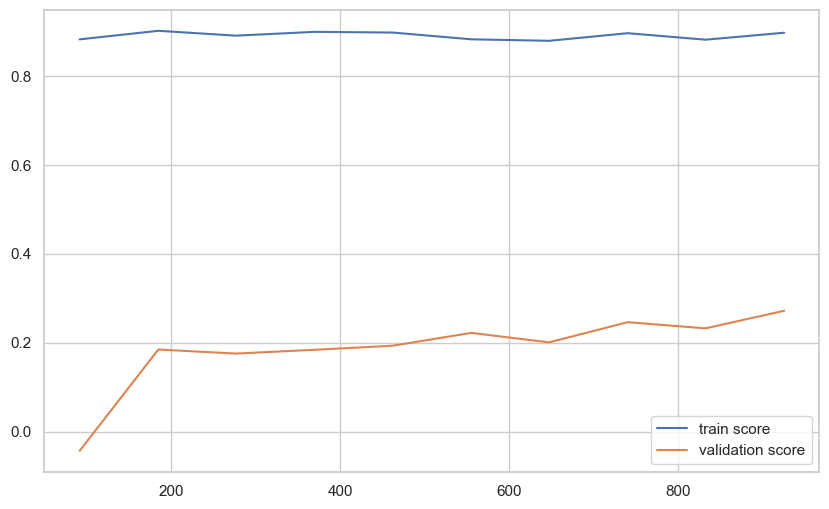

Xgb
RMSE : 1.3422365441762318
MAE : 1.0566305302597994
R² : 0.20287576603094726


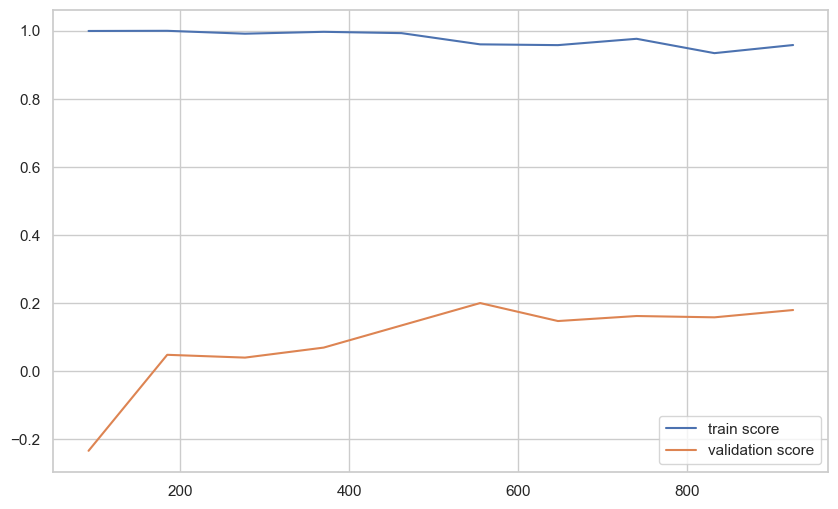

SVR
RMSE : 1.2122014571424409
MAE : 0.9688061570824432
R² : 0.3498441145192145


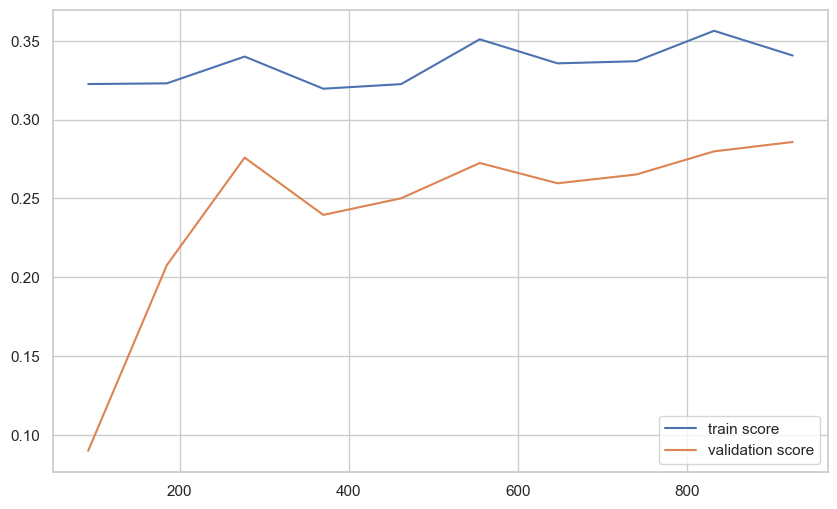

KNeighbors
RMSE : 1.3853337484601627
MAE : 1.1269758190662653
R² : 0.15086503656454908


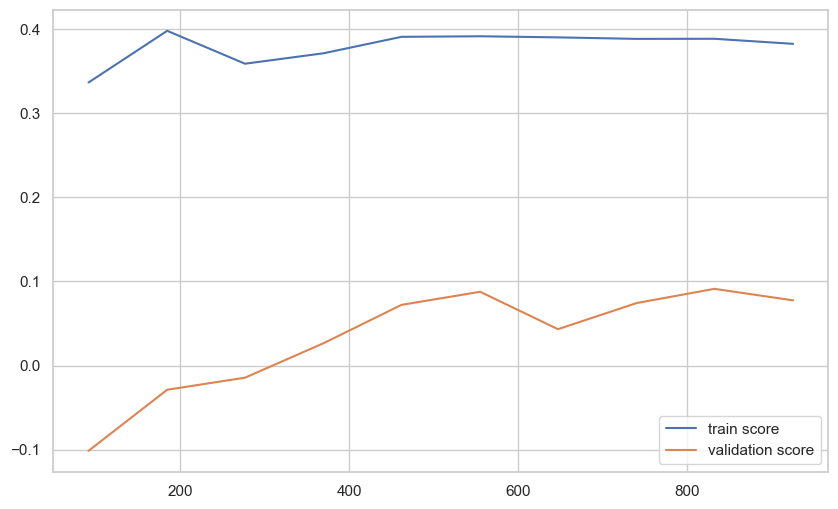

In [70]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## Le Tunning des hyperparamètres
- **RandomForest :**
    - {'n_estimators': 250, 'min_samples_split': 20, 'max_features': 'log2', 'max_depth': 10, selectkbest__k': 10} avec RandomizedSearchCV
    - {'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 250} avec un gridSearchCV
- **SVR :**
    - {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 1, 'C': 100} avec RandomizedSearchCV
    - {'C': 50, 'epsilon': 0.5, 'gamma': 0.2} avec un gridSearchCV

In [81]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
# a tester après Bayesian Optimization (Optuna, Hyperopt)

### RandomForest

In [89]:
param_grid_1 = {
    'pipeline__selectkbest__k': np.arange(5, 12),  # Tester entre 5 et 12 variables
    'randomforestregressor__n_estimators': np.arange(50, 300, 50),  
    'randomforestregressor__max_depth': [None, 10, 20, 30, 40, 50], 
    #'randomforestregressor__min_samples_split': [2, 5, 10],  
    #'randomforestregressor__min_samples_leaf': [1, 2, 4], 
    #'randomforestregressor__max_features': [ 'sqrt', 'log2']  # Sélection de features
}

In [91]:
grid_1 = RandomizedSearchCV(RandomForest, param_grid_1, n_iter=100, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1, verbose=2, random_state=0)

In [93]:
grid_1.fit(X_train, y_train)
print(grid_1.best_params_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
{'randomforestregressor__n_estimators': 250, 'randomforestregressor__max_depth': 10, 'pipeline__selectkbest__k': 11}


RMSE : 1.132618246698165
MAE : 0.8871812814761216
R² : 0.43240965053137226


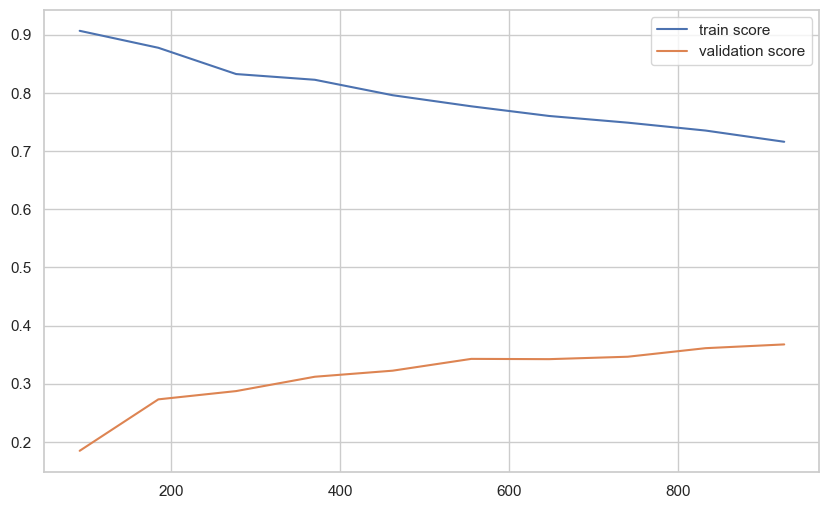

In [95]:
evaluation(grid_1.best_estimator_)

In [97]:
# Nouvelle grille basée sur les meilleurs résultats de RandomizedSearchCV ( à travailler deçu avant de prati)
param_grid_2 = {
    'pipeline__selectkbest__k': [10,11,12,13],  # Autour de 12
    'randomforestregressor__n_estimators': [220, 250, 270],  # Autour de 100
    'randomforestregressor__max_depth': [8, 10, 12],  # Autour de 10
    #'randomforestregressor__min_samples_split': [2, 3, 5],  # Autour de 2
    #'randomforestregressor__min_samples_leaf': [1, 2],  # Autour de 1
    #'randomforestregressor__max_features': ['log2']  # On garde log2
}

In [99]:
grid_2 = GridSearchCV(
    RandomForest, param_grid_2, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1, verbose=2
)

In [101]:
grid_2.fit(X_train, y_train)
print(grid_2.best_params_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'pipeline__selectkbest__k': 11, 'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 270}


RMSE : 1.131405884419905
MAE : 0.8856586792155874
R² : 0.4336241053475378


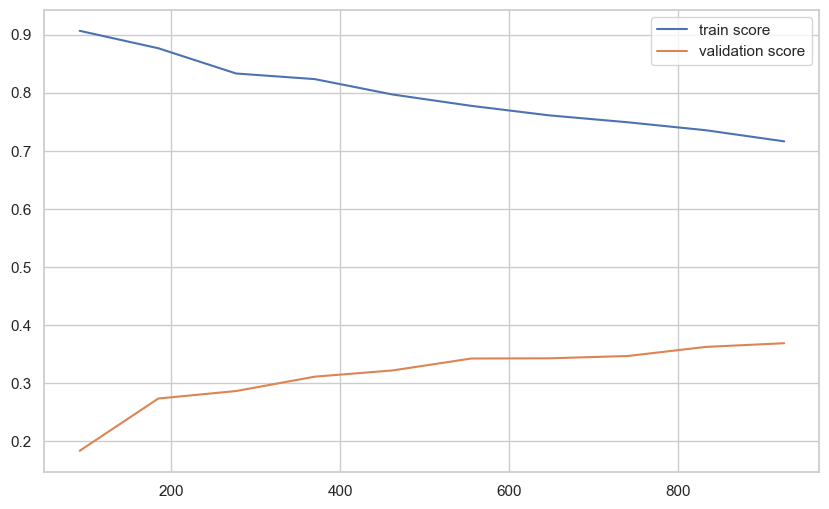

In [103]:
evaluation(grid_2.best_estimator_)

### SVR

In [113]:
param_grid_svr = {
    'pipeline__selectkbest__k': np.arange(5, 13),
    #'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.001, 0.01, 0.1, 1],
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__gamma': [ 0.01, 0.1, 1]
}

In [115]:
grid_SVR_1 = RandomizedSearchCV(SVR, param_grid_svr, n_iter=20, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1, verbose=2, random_state=0)

In [117]:
grid_SVR_1.fit(X_train, y_train)
print(grid_SVR_1.best_params_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
{'svr__kernel': 'rbf', 'svr__gamma': 0.1, 'svr__epsilon': 1, 'pipeline__selectkbest__k': 12}


RMSE : 1.1634980426168695
MAE : 0.9083673137282269
R² : 0.40103808469994573


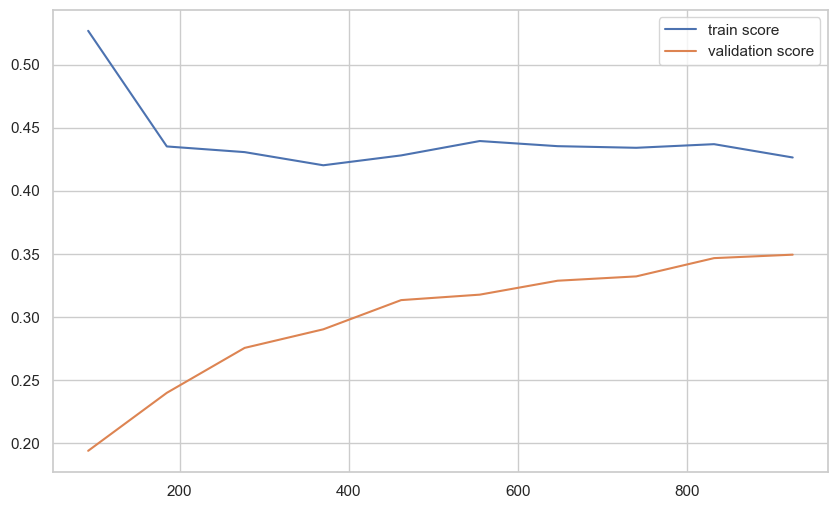

In [119]:
evaluation(grid_SVR_1.best_estimator_)

In [123]:
param_grid_svr = {
    'pipeline__selectkbest__k': [11,12,13],
    #'svr__C': [50, 100, 150],  # On affine autour de 100
    'svr__epsilon': [0.5, 1, 1.5],  # On teste des valeurs proches de 1
    'svr__kernel': ['rbf'],
    'svr__gamma': [0.05, 0.1, 0.2]  # On affine autour de 0.1
}

In [125]:
grid_SVR_2 = GridSearchCV(
    SVR, param_grid_svr, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1, verbose=2
)

In [127]:
grid_SVR_2.fit(X_train, y_train)
print(grid_SVR_2.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
{'pipeline__selectkbest__k': 11, 'svr__epsilon': 0.5, 'svr__gamma': 0.05, 'svr__kernel': 'rbf'}


RMSE : 1.1519640060693421
MAE : 0.8967532850297845
R² : 0.4128545309880425


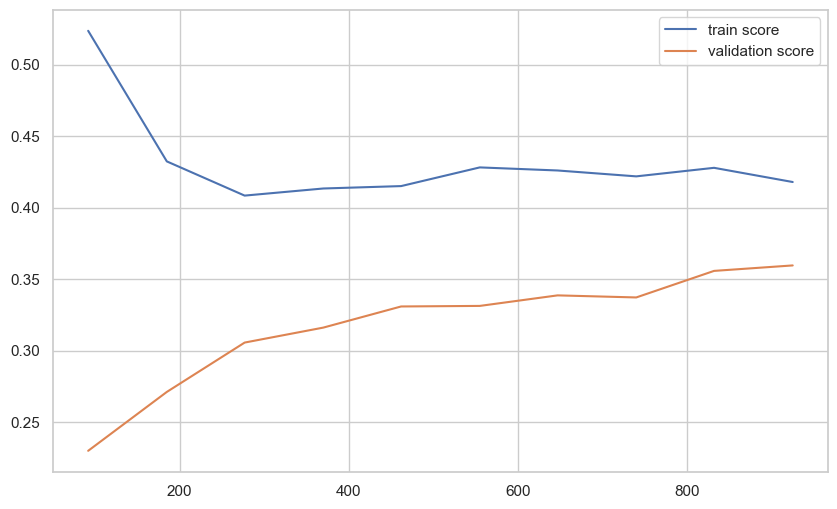

In [129]:
evaluation(grid_SVR_2.best_estimator_)

## Explication de mes model deux model

### Lime
- Quand on entraîne un modèle comme RandomForest ou SVR, il est souvent complexe et difficile à interpréter.
➡ LIME aide à comprendre pourquoi le modèle donne une certaine prédiction pour un exemple spécifique.

🔹 Exemple concret

Ton modèle prédit que Bâtiment A = 20 tonnes de CO₂
LIME va dire quelles variables (ex : surface, âge du bâtiment, ENERGY STAR Score…) ont le plus influencé cette prédiction.

In [141]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Les données d'entraînement (sans la cible)
    feature_names=X_train.columns, # Nom des features
    verbose=True,
    mode='regression'  # Car notre modèle prédit une valeur continue
)

i = 3  # Index de l'exemple qu'on veut expliquer
example = X_test.iloc[i]  # Récupérons l'exemple

# Générer l'explication pour cet exemple avec le modèle
exp = explainer.explain_instance(
    data_row=np.array(example),
    predict_fn=SVR.predict  # ou RandomForest.predict (Fonction de prédiction de mon modèle)
)


# Afficher l'explication
exp.show_in_notebook(show_table=True)

Intercept 6.7538984416425585
Prediction_local [3.12721885]
Right: 2.880254673623644


### Shapley Values
- Les Shapley Values sont une méthode mathématique issue de la théorie des jeux pour expliquer l’impact des variables sur une prédiction.
Elles permettent de répondre à la question :

📌 "Quelle est la contribution de chaque variable à la prédiction d'un modèle ?"

In [153]:
import shap
# Pour RandomForest, on utilise TreeExplainer
explainer = shap.TreeExplainer(model)  # Modèle à expliquer
shap_values = explainer.shap_values(X_test)   # Calcul des Shapley Values
# Pour SVR (ou autres modèles non arborescents), on utilise KernelExplainer :
'''explainer = shap.KernelExplainer(SVR.predict, X_train.sample(100))  # Approche approximative
shap_values = explainer.shap_values(X_test)'''

'explainer = shap.KernelExplainer(SVR.predict, X_train.sample(100))  # Approche approximative\nshap_values = explainer.shap_values(X_test)'

In [157]:
# Expliquer un seul exemple (localement)
i = 3  # Exemple à expliquer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

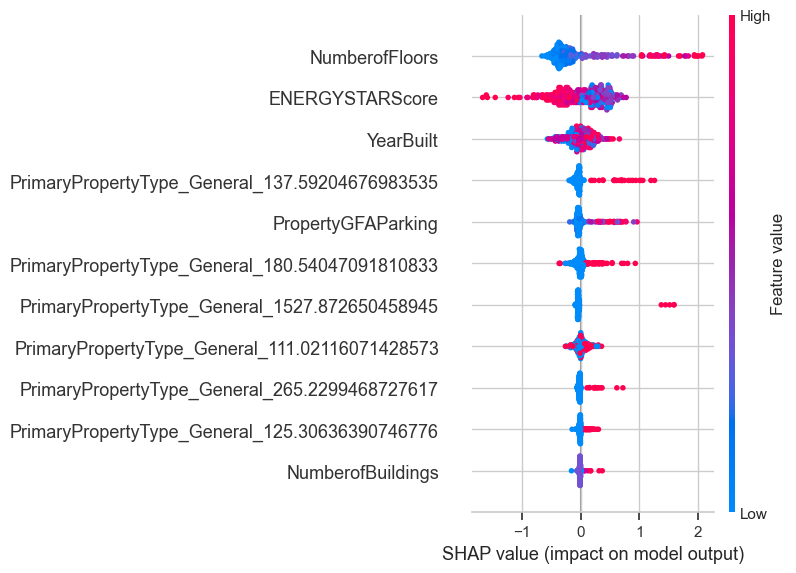

In [169]:
# Visualiser l’impact global des variables
shap.summary_plot(shap_values, X_test) # ou, plot_type="bar")

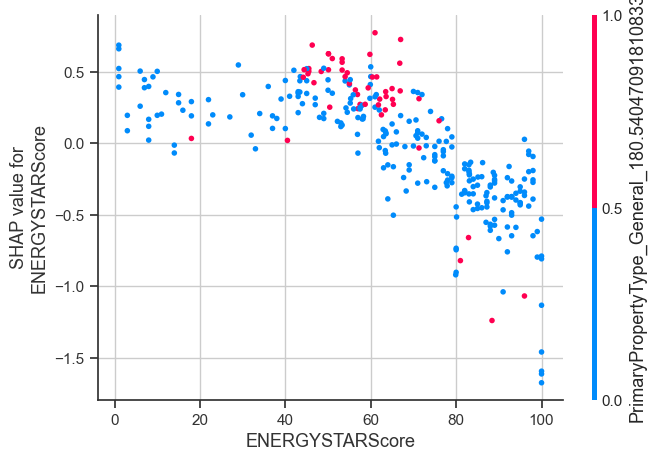

In [163]:
# Visualiser les effets individuels
# Testons l’impact de l’"ENERGY STAR Score" et voir s’il est pertinent pour la prédiction.
shap.dependence_plot("ENERGYSTARScore", shap_values, X_test)

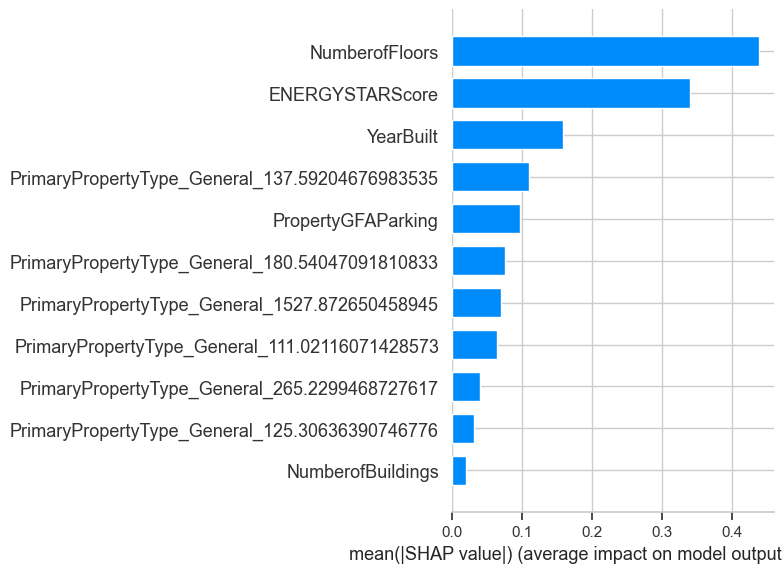

### La Permutation Importance
- La Permutation Importance est une méthode simple et efficace pour mesurer l'importance des variables dans un modèle.

📌 Elle permet de répondre à la question : "Quelle est l’influence d’une variable sur la performance du modèle ?"

In [182]:
from sklearn.inspection import permutation_importance

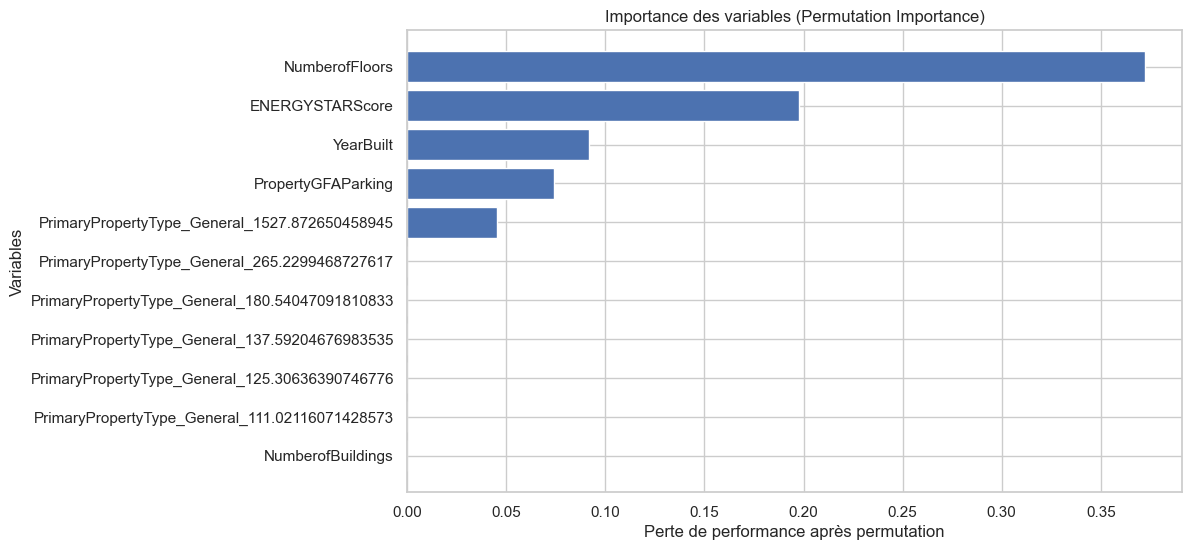

In [184]:
# Calculer l'importance des variables par permutation
result = permutation_importance(RandomForest, X_test, y_test, scoring='r2', n_repeats=5, random_state=0)

# Trionq les variables par importance
sorted_idx = np.argsort(result.importances_mean)

# Afficher le graphique
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel("Perte de performance après permutation")
plt.ylabel("Variables")
plt.title("Importance des variables (Permutation Importance)")
plt.show()

### shapash Monitoring
- Shapash est une bibliothèque Python qui facilite l’interprétation des modèles de Machine Learning. Elle est particulièrement utile pour visualiser et expliquer l’impact des variables sur les prédictions. Contrairement à SHAP et LIME, qui nécessitent souvent plusieurs lignes de code, Shapash fournit une interface plus simple et intuitive.

In [197]:
from shapash.explainer.smart_explainer import SmartExplainer

In [ ]:
#  Créer et compiler l’explicateur Shapash
# Initialiser l'explicateur
# Initialiser l'explicateur
xpl = SmartExplainer(model=RandomForest)  # Assure-toi que "model" est bien ton RandomForestRegressor entraîné

# Compiler avec les données test
xpl.compile(x=X_test, y_pred=model.predict(X_test))

# Afficher l'importance des features
xpl.plot.features_importance()

In [ ]:
# Visualiser l’explication globale
xpl.plot.features_importance()

In [ ]:
# Analyser une prédiction individuelle
xpl.plot.contribution_plot(index=0)

In [ ]:
# Explorer les résultats en mode interactif
xpl.to_dashboard()